# Introduction

Recursive Feature Elimination Cross Validation (RFECV) is a useful dimensionality reduction technique that removes unimportant features that lower the accuracy of your model, and thus makes a simpler model that will be less prone to overfitting. I have seen many Kagglers implement it through sklearn's RFECV class, but there is a lack of deeper understanding beyond knowing it picks out an optimal subset of features to be fed into your model. This will create situations where RFECV may produce misleading results, or less flexibility while data modelling as you don't know what is actually going on. This isn't helped by the fact the documentation provided is also pretty vague on how exactly this method works.

Therefore, this kernel will build RFECV from first principlies, and take you through the process of selecting these subsets of features. I will also show the practical way to implement it using the in-built fuction scikit.model_selection.RFECV, and discuss the precautions needed when using this technique.

## Contents

1. **[Building RFECV: From the Ground Up](#1)**
    1. [Feature importances](#2)
    2. [RFE (Recursive Feature Elimination)](#3)
    3. [Implementing Cross Validation](#4)
2. **[Implementing RFECV using scikit](#5)**
3. **[RFECV for Correlated Features](#6)**
4. **[Tree-based disadvantages](#7)**
    1. [Warning 1: Feature importances of an overfitted model are misleading](#8)
    2. [Warning 2: Increase Cardinality spells Doom](#9)
5. **[Conclusion](#10)**

As the main focus of the kernel is showcasing RFECV, the common steps of EDA, data cleaning, feature engineering and encoding will NOT be focused on. The following cell is my own personal processing of the datasets, though I encourage you to follow your own methods and adjust my transformations to your own when you explore this kernel.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

train = pd.read_csv("/kaggle/input/titanic/train.csv")

# Fill Null Values
train["Fare"].fillna(train["Fare"].median(), inplace = True)
train["Embarked"].fillna(train["Embarked"].mode(), inplace = True)
age_avg, age_std = train["Age"].mean(), train["Age"].std()
random_values = np.random.normal(age_avg, age_std, size=len(train))
train["Age"].fillna(pd.Series(random_values), inplace=True)
train["Age"] = np.ceil(train["Age"]).astype(int)

# Create FamSize and IsAlone variables
train["FamSize"] = train["SibSp"] + train["Parch"] + 1
train["IsAlone"] = 0
train.loc[train["FamSize"] == 1, "IsAlone"] = 1
    
# Categorise "continuous" variables
train["CatAge"] = pd.cut(train["Age"], bins=pd.cut(train["Age"], bins=5).cat.categories).cat.codes
train["CatFare"] = pd.cut(train["Fare"], bins=pd.qcut(train["Fare"], q=5).cat.categories).cat.codes
   
# For Sex use Label Encoding
train["Sex_Code"] = train["Sex"].map({"female": 0, "male": 1})

# For Embarked use One Hot Encoding
train[["Embarked_C", "Embarked_Q", "Embarked_S"]] = pd.get_dummies(train["Embarked"]).astype(int)

In [2]:
x_var = ["Pclass", "SibSp", "FamSize", "IsAlone", "Parch", "CatAge", "CatFare",
         "Sex_Code", "Embarked_C", "Embarked_Q", "Embarked_S"]

y_var = ["Survived"]

train[x_var + y_var]

Pclass  SibSp  FamSize  IsAlone  Parch  CatAge  CatFare  Sex_Code  \
0         3      1        2        0      0       1        0         1   
1         1      1        2        0      0       2        4         0   
2         3      0        1        1      0       2        1         0   
3         1      1        2        0      0       2        4         0   
4         3      0        1        1      0       2        1         1   
..      ...    ...      ...      ...    ...     ...      ...       ...   
886       2      0        1        1      0       2        2         1   
887       1      0        1        1      0       1        3         0   
888       3      1        4        0      2       2        3         0   
889       1      0        1        1      0       2        3         1   
890       3      0        1        1      0       2        0         1   

     Embarked_C  Embarked_Q  Embarked_S  Survived  
0             0           0           1         0  
1             1           0           0         1  
2             0           0           1         1  
3             0           0           1         1  
4             0           0           1         0  
..          ...         ...         ...       ...  
886           0           0           1         0  
887           0           0           1         1  
888           0           0           1         0  
889           1           0           0         1  
890           0           1           0         0  

[891 rows x 12 columns]

Now we have a processed dataset which we can investigate feature elimination on. For our exploration, let us use a Decision Tree as our base model. This can be replaced by whichever model you wish to optimise the selected features for.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

model = DecisionTreeClassifier(random_state = 6, max_depth=3)
#model = XGBClassifier(seed=0)

X = train[x_var]
y = train[y_var]

<a id="1"></a>
# Building RFECV: From the Ground Up
</br>
Break down the goal of RFECV: To choose the best subset of features for your dataset and model. But how do we even define a "best" feature?
</br>

<a id="2"></a>
## Feature Importances

Some may have the idea to use the *feature_importances*_ attribute that is available for many ML algorithms. These feature importances are calculated differently depending on the chosen algorithm, but the final output is always the same: an array containing an importance score for each feature in your dataset. **This concept is the basis of RFECV.**

In [9]:
model.fit(X, y)
pd.DataFrame({"Features": X.columns, "Importances": model.feature_importances_})

Features  Importances
0       Pclass     0.179931
1        SibSp     0.041503
2      FamSize     0.059860
3      IsAlone     0.012349
4        Parch     0.032653
5       CatAge     0.118647
6      CatFare     0.078835
7     Sex_Code     0.428799
8   Embarked_C     0.017340
9   Embarked_Q     0.002708
10  Embarked_S     0.027375

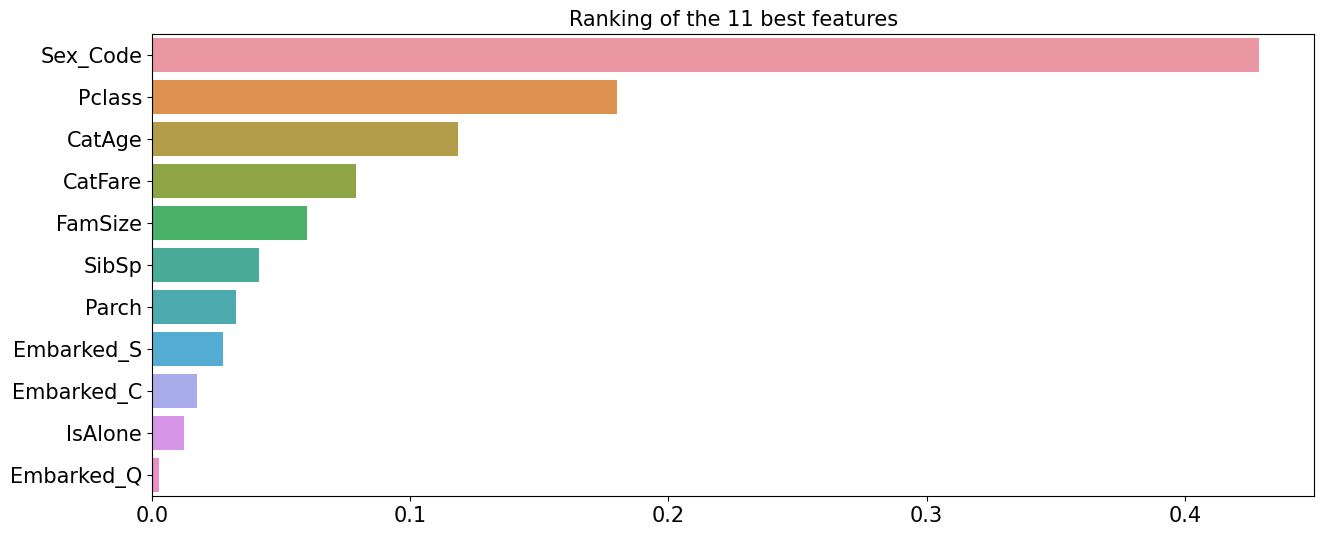

In [22]:
def plot_feature_importances(feat, feat_import):
    """Plot feature importance scores against features"""
    df = pd.DataFrame({"Features": feat, "Importances": feat_import})
    plt.figure(figsize=(15, 6))
    sns.barplot(x="Importances", y="Features", data = df.sort_values("Importances", ascending=False))

    plt.xlabel("")
    plt.ylabel("")
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)
    plt.title(f"Ranking of the {len(feat)} best features", size=15)

    plt.show()

model.fit(X, y)    
plot_feature_importances(X.columns, model.feature_importances_)

However, this ranking is somewhat deceptive as **the top 4 features in these rankings are not necessarily the best 4 features.**

What does this mean? From the above graph, we infer that the best 4 features are:
1. Sex_Code
2. Pclass
3. CatAge
4. FamSize

So let us try fitting our model on just these 4 best features. Our data and model are staying the same, so the rankings should be the same right?

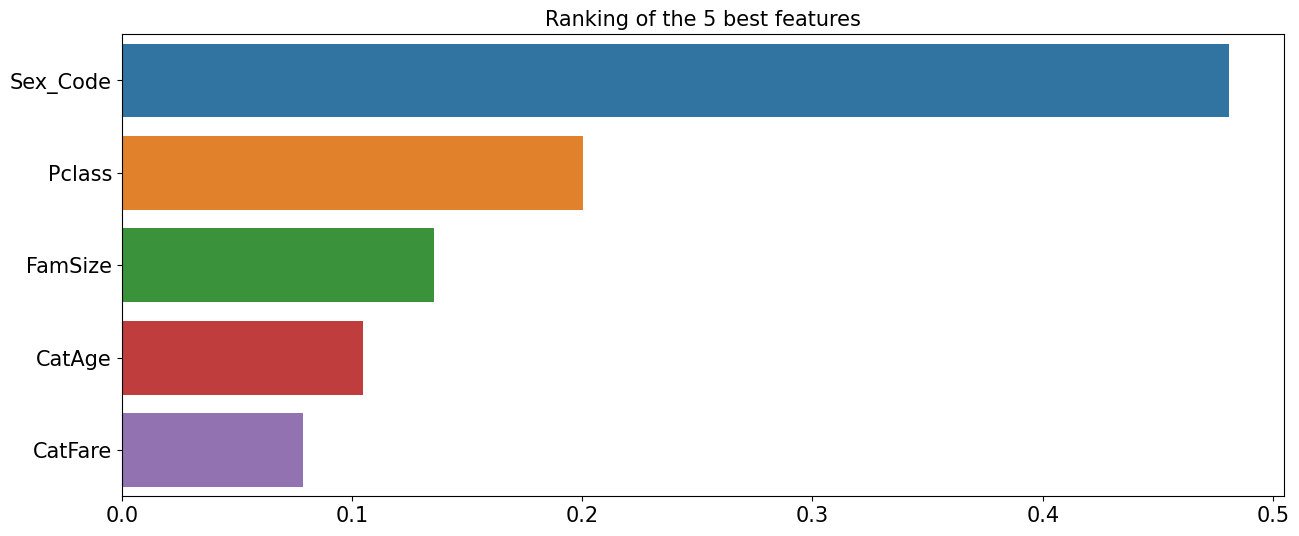

In [12]:
X_sub = X[["Sex_Code", "Pclass", "FamSize", "CatAge", "CatFare"]]

model.fit(X_sub, y)
plot_feature_importances(X_sub.columns, model.feature_importances_) # defined in previous hidden cell

After taking a subset of the best 4 features in the original graph, now the ordering of number 3 and 4 have switched. 

1. Sex_Code
2. Pclass
3. FamSize
4. CatAge

Why does the presence of other features affect the feature importance ranking? This is because feature importances are dependent on the predictive power of a feature. And this predictive power can vary based on its correlation with other features in the dataset. In our case, our feature "FamSize" was more important than "CatAge" when the top 4 features were included, but had dropped in the ranking with all 11 features included, since you already had the other features "SibSp" and "ParCh" which are correlated to "FamSize". The predictive power was in a way distributed to these other features "SibSp" and "ParCh".

The interaction between all the different features makes it hard to identify if one feature is better than another. This is a good starting point but we need a better way of ranking features which takes into account all the other features.

</br>

<a id="3"></a>
## Recursive Feature Elimination (RFE)

The RFE method iteratively identifies the most important features in a dataset by removing the least important feature in each iteration. The steps are:

1. Fit your model on the dataset
2. Call the feature importance ranking
3. Remove the lowest ranked feature
4. Repeat steps 1-3 until you reach desired number of "best" features

For example, the best 10 features are selected by calling the feature importance ranking and removing the lowest ranked feature. The best 9 features are selected by refitting your model on these 10 features, calling the feature importance ranking, and removing the lowest ranked feature among them.  <br> This is different from a simple feature importance ranking since we have seen previously that the lowest ranked feature may change after removing a feature and reranking.

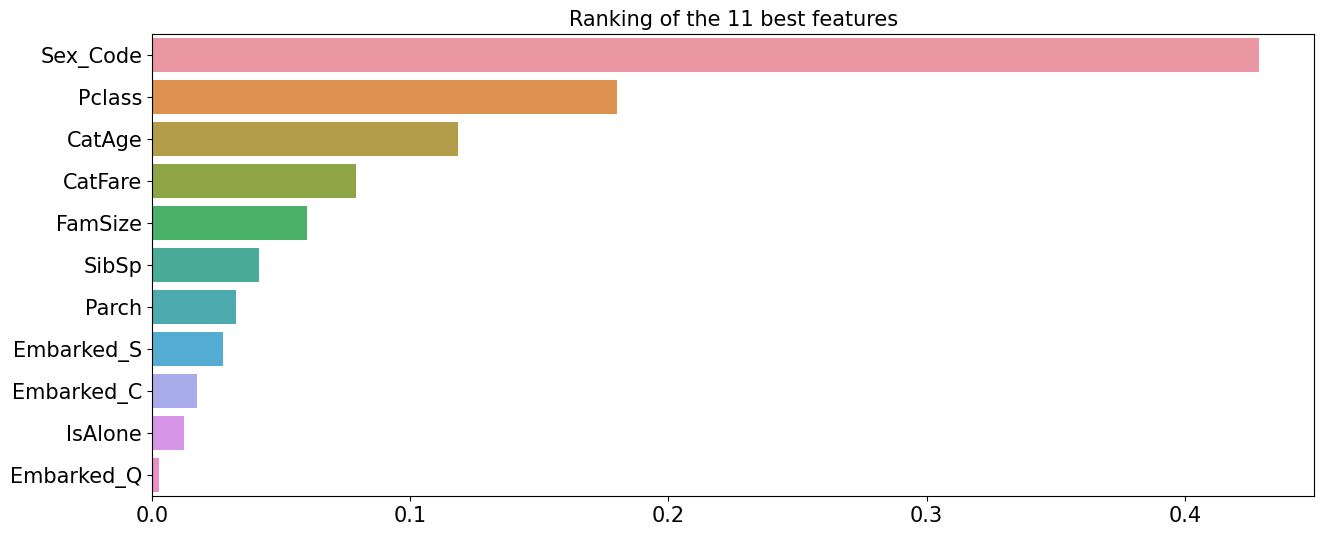

Removing: Embarked_Q
----------


Removing: IsAlone
----------


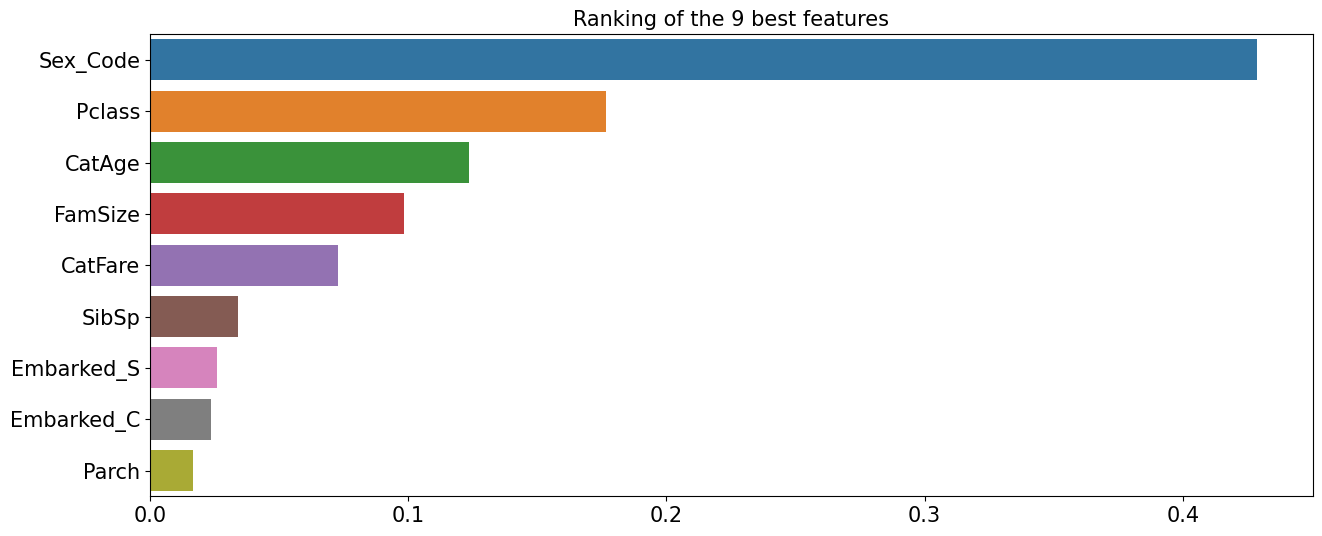

Removing: Parch
----------


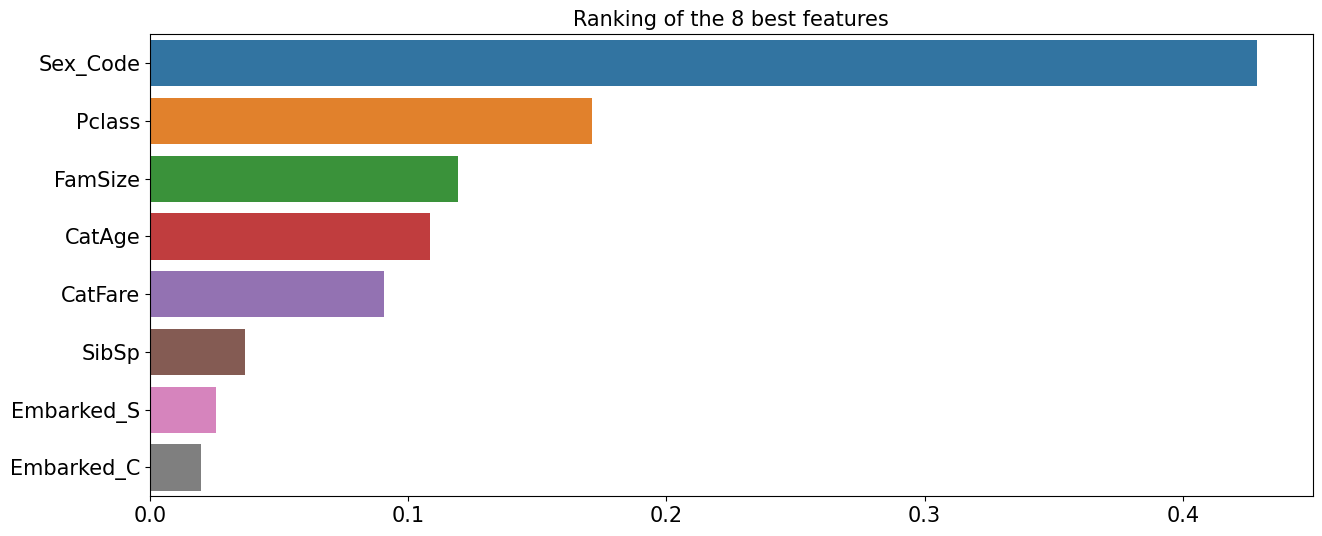

Removing: Embarked_C
----------


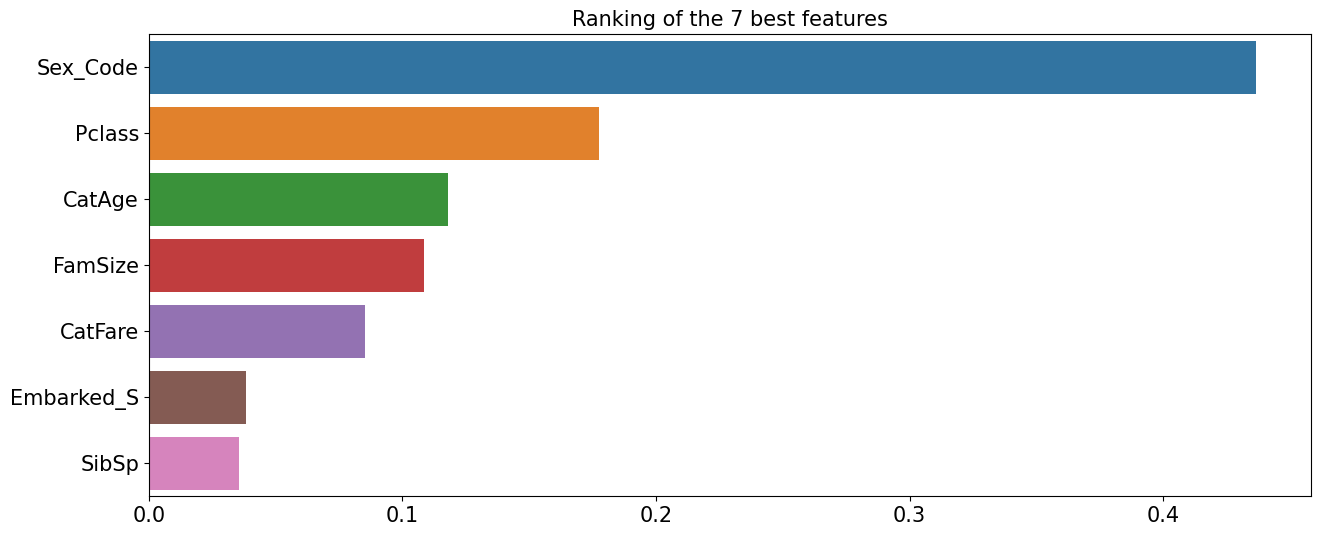

Removing: SibSp
----------


Removing: Embarked_S
----------


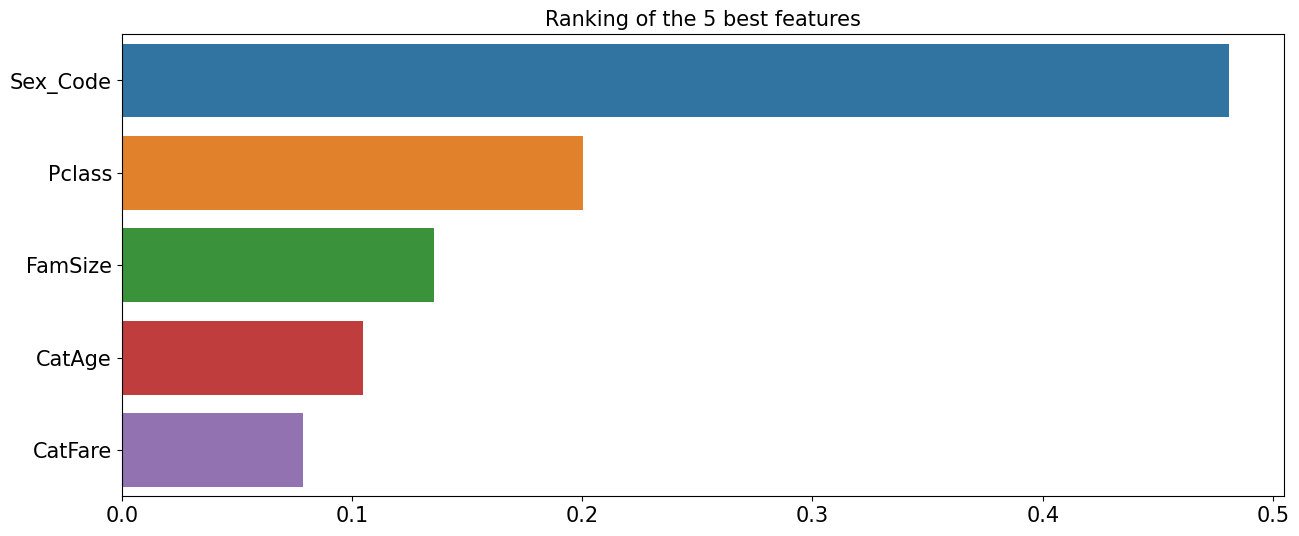

Removing: CatFare
----------


Removing: CatAge
----------


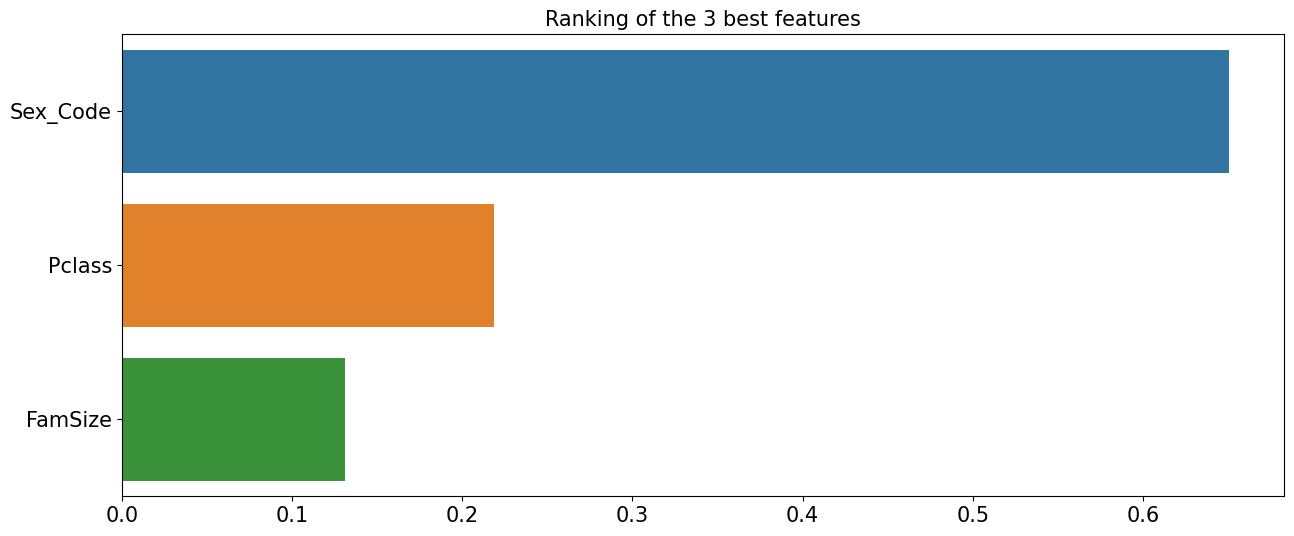

Removing: FamSize
----------


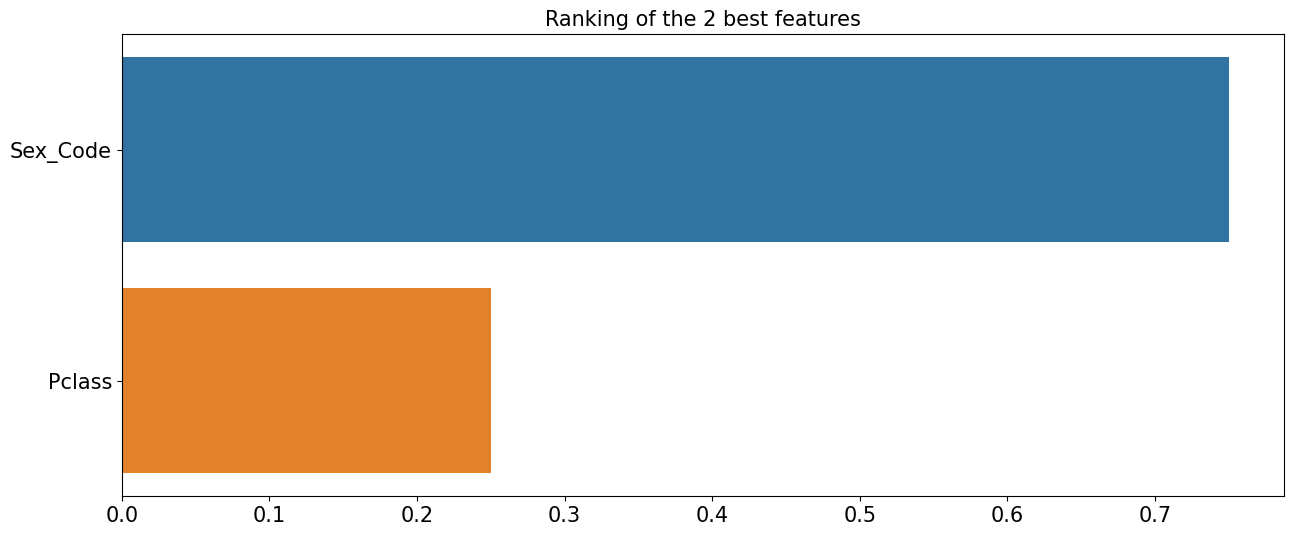

Removing: Pclass
----------


Removing: Sex_Code
----------


In [66]:
features = x_var.copy()

for _ in range(len(x_var)):
    model.fit(train[features], y)
    plot_feature_importances(features, model.feature_importances_)
    lowest_rank = features[np.argmin(model.feature_importances_)]
    print("Removing:", lowest_rank)
    features.remove(lowest_rank)
    print("-"*10)

**Observation:** These graphs again show an interesting pattern with feature "Embarked_S". This was the second lowest ranked feature in the third and fourth iteration, but managed to move higher after the reranking and ended up being the fifth feature removed. This is because by removing "Embarked_C" and "Embarked_Q" which are correlated variables, "Embarked_S" had gained more predictive power. 

We can use this to create a function stops at a certain iteration, which essentially selects the best "n" features.

In [6]:
def rfe_function(alg, X, y, n_features_to_select):
    features = list(X.columns)

    for _ in range(len(X.columns) - n_features_to_select):
        alg.fit(X[features], y)
        lowest_rank = features[np.argmin(alg.feature_importances_)]
        features.remove(lowest_rank)
    
    return features

We have developed a better method called RFE to rank all the feature importances and identify the best features! But how do we know how many features we should select for our model?  <br> Do we take the best 5 features? The best 10? We also need to devise a method to find the optimal number of features. 

One idea is to use a scoring metric in between each RFE iteration, and obtain a score for each number of features selected. This will help identify the point at which we are underfitting the model by removing too many features. However, since we have introduced a scoring metric, we need to be cautious of overfitting the model as well. We can address this the same way we generally address overfitting - by implementing cross-validation.

</br>

<a id="4"></a>
## Implementing Cross Validation

Recursive Feature Elimination with Cross-Validation (RFECV) is the technique obtained when we combine RFE and cross-validation.  <br> 
By identifying the number of features that consistently improve model performance over multiple folds, RFECV mitigates overfitting concerns.

The detailed process of RFECV is as follows:

1. Divide your dataset into different folds using a Cross-Validation Split.
2. Apply RFE with scoring on the first fold:
    1. Fit your model on the training data from the first fold.
    2. Evaluate the model's performance on the test data from the first fold using a chosen scoring metric.
    3. Obtain the feature importance ranking from the trained model.
    4. Remove the lowest ranked feature.
    5. Repeat steps A-D until all number of features have been iterated over to create an array of "Number of features vs Score."
3. Repeat step 2 for all other folds, ensuring each time you retrain on the training data and evaluate on the test data.
4. Average the model scores obtained from each fold and identify the optimal number of features that resulted in the highest average score.
5. Apply RFE once to the entire dataset using the optimal number of features:
    1. Refit your model onto the entire dataset.
    2. Obtain the feature importance ranking from the refitted model.
    3. Remove the lowest ranked feature.
    4. Repeat steps A-C until the number of features is equal to the optimal number of features.

</br>

**Step 1:** We will use a Stratified 5-fold CV split for our feature selection process. I have chosen only 5 folds since the size of the entire dataset is fairly small, and creating too many folds will make the size of the testing sets within each fold too small. We also have used a Stratified version since our target variable "Survived" is unbalanced, there are more casualties compared to survivors.

If you do not set a random_state to our cv_split, then you can potentially get slightly different results each time.

In [5]:
from sklearn.model_selection import StratifiedKFold

cv_split = StratifiedKFold(5, shuffle=True, random_state=0)

**Step 2:** Firstly, let us modify our previous function slightly so that it can retrieve a score upon each iteration. We can store this in the array "scores_array".

We have changed the function in 3 ways:

* Created a scores array to store the score for each number of features
* Created a way to update that scores array within the loop
* Set the n_features_to_select variable to 0, since we want the function to iterate over every possibile number of features

In [69]:
from sklearn.metrics import accuracy_score

def score(alg, x_train, x_test, y_train, y_test):
    """Calculate the accuracy score of the algorithm."""
    alg.fit(x_train, y_train)
    y_pred = alg.predict(x_test)
    return accuracy_score(y_test, y_pred)

def rfe_function2(alg, x_train, x_test, y_train, y_test):
    features = list(x_train.columns)
    scores_array = np.empty(len(features))
    for i in range(len(features)):
        # Define a scoring metric for the model
        scores = score(alg, x_train[features], x_test[features],
                       y_train, y_test)
        scores_array[-i-1] = scores
        
        # Remove lowest ranked feature
        alg.fit(x_train[features], y_train)
        lowest_rank = features[np.argmin(alg.feature_importances_)]
        features.remove(lowest_rank)
    
    return scores_array

**Step 3:** We should work seperately on each fold, and apply our new RFE function on each one. We can do this using a for loop over the cross validation split. Let us store the results for each fold in a dictionary "dic".

In [70]:
def rfecv_function(alg, X, y, cv):
    dic = {}
    for fold_index, (train_index, test_index) in enumerate(cv.split(X, y)):
            x_train_fold, y_train_fold = X.iloc[train_index], y.iloc[train_index]
            x_test_fold, y_test_fold = X.iloc[test_index], y.iloc[test_index]
            dic[f"split{fold_index}_test_score"] = rfe_function2(alg, x_train_fold, x_test_fold, y_train_fold, y_test_fold)
    return dic

fold_test_scores = rfecv_function(model, train[x_var], train[y_var], cv_split)
fold_test_scores

{'split0_test_score': array([0.82122905, 0.80446927, 0.81564246, 0.82681564, 0.8547486 ,
        0.83798883, 0.84357542, 0.84916201, 0.84916201, 0.83798883,
        0.84357542]),
 'split1_test_score': array([0.84831461, 0.80337079, 0.84831461, 0.84269663, 0.80337079,
        0.79213483, 0.80337079, 0.80337079, 0.80898876, 0.80337079,
        0.81460674]),
 'split2_test_score': array([0.79213483, 0.78089888, 0.79213483, 0.81460674, 0.82022472,
        0.79775281, 0.78651685, 0.78089888, 0.79213483, 0.79213483,
        0.79775281]),
 'split3_test_score': array([0.73033708, 0.73595506, 0.73595506, 0.74719101, 0.79213483,
        0.78089888, 0.79213483, 0.78651685, 0.78651685, 0.78651685,
        0.79775281]),
 'split4_test_score': array([0.74157303, 0.74157303, 0.75842697, 0.76404494, 0.7752809 ,
        0.75280899, 0.75842697, 0.76966292, 0.75842697, 0.75842697,
        0.75842697])}

**Step 4:** Average the test scores over all cross validation folds. We then identify the number of features with the highest averaged test score, and select that as the optimal number of features.

In [71]:
mean_test_scores = np.mean(list(fold_test_scores.values()), axis=0)
n_scores = len(mean_test_scores)
display(pd.DataFrame({"Number of Features": range(1, n_scores + 1), "Test Scores": mean_test_scores}).set_index("Number of Features"))

# Visualise the scores in a line graph
plt.figure(figsize=(15,10))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.plot(range(1, n_scores + 1), mean_test_scores)
plt.title("Number of Features vs Test Accuracy")
plt.show()

optimal_number_of_features = np.argmax(mean_test_scores) + 1
print(f"Optimal number of features: {optimal_number_of_features}")

Test Scores
Number of Features             
1                      0.786718
2                      0.773253
3                      0.790095
4                      0.799071
5                      0.809152
6                      0.792317
7                      0.796805
8                      0.797922
9                      0.799046
10                     0.795688
11                     0.802423

Optimal number of features: 5


**Step 5:** Now we have identified the optimal number of features that maximises the performance of our model, we can use the original RFE function we have previously defined to show which features were actually selected.

In [72]:
print(f"Selected features: {rfe_function(model, X, y, n_features_to_select = optimal_number_of_features)}")

Selected features: ['Pclass', 'FamSize', 'CatAge', 'CatFare', 'Sex_Code']


And with that step, we have completed RFECV and selected a subset of features to maximise our models performance!

</br>

<a id="5"></a>
# How to use RFECV from sklearn

That was a fairly long process of feature selection, so let's see the practical shortcut to implement this technique using sklearn. Here are some of the important parameters that you should understand:

**estimator:** The model for which you are optimising feature selection.

**step:** Number of features which are removed in each RFE iteration. We have tested this with a single step, but if there are many features in your dataset you can increase this to speed up the process.

**min_features_to_select:** Set a cap on the number of features that can be removed. We will not set any limit on the minimum number of features, so we set this to 1.

**cv:** The cross validation split used. Similar to the previous section, we will use the same Stratified 5-fold split.

**scoring:** The evaluation metric to score the test sets in each cross-validation fold. In the previous section we had used accuracy,and we will use the same here.

**n_jobs:** Number of cores used for the training process. If set to -1, all cores are used.

</br>

You can check out the official Sklearn decomentation for more information on parameters, attributes, and methods for the RFECV function: </br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

cv_split = StratifiedKFold(5, shuffle=True, random_state=0)

rfecv = RFECV(
    estimator=model,
    step=1,
    min_features_to_select=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Optimal features: {list(rfecv.get_feature_names_out())}")

Optimal number of features: 5
Optimal features: ['Pclass', 'FamSize', 'CatAge', 'CatFare', 'Sex_Code']


The attribute **.cv_results_** returns arrays of scores from each split, and also the aggregated (mean) scores over all folds in "mean_test_score". We have calculated both of these in the previous section, so we compare the sklearn method with the results we have obtained from the previous section.

In [74]:
rfecv.cv_results_

{'mean_test_score': array([0.78671772, 0.77325341, 0.79009478, 0.79907099, 0.80915197,
        0.79231687, 0.79680497, 0.79792229, 0.79904589, 0.79568765,
        0.80242295]),
 'std_test_score': array([0.04523577, 0.02944403, 0.03995085, 0.03696668, 0.0270995 ,
        0.02759258, 0.02768072, 0.02783404, 0.02988352, 0.02582055,
        0.02764503]),
 'split0_test_score': array([0.82122905, 0.80446927, 0.81564246, 0.82681564, 0.8547486 ,
        0.83798883, 0.84357542, 0.84916201, 0.84916201, 0.83798883,
        0.84357542]),
 'split1_test_score': array([0.84831461, 0.80337079, 0.84831461, 0.84269663, 0.80337079,
        0.79213483, 0.80337079, 0.80337079, 0.80898876, 0.80337079,
        0.81460674]),
 'split2_test_score': array([0.79213483, 0.78089888, 0.79213483, 0.81460674, 0.82022472,
        0.79775281, 0.78651685, 0.78089888, 0.79213483, 0.79213483,
        0.79775281]),
 'split3_test_score': array([0.73033708, 0.73595506, 0.73595506, 0.74719101, 0.79213483,
        0.78089888, 0

In [75]:
np.array_equal(mean_test_scores, rfecv.cv_results_["mean_test_score"])

True

NOTE: previous versions of scikit have used rfecv.grid_scores_ instead of rfecv.cv_results_["mean_test_score"] but this has been depreciated and you should use the latter instead.

In [76]:
# Check results within each fold is equal to our previous variable fold_test_scores
results2 = {key: rfecv.cv_results_[key] for key in list(rfecv.cv_results_.keys())[2:]}
all(np.array_equal(fold_test_scores[key], results2[key]) for key in fold_test_scores)

True

Let us visualise these test scores from the in-built method similar what we did in the previous section, and find identical results for "Number of Features vs Test Scores". In this graph we have also added a background fill to cover one standard deviation away from the mean test scores.

In [7]:
def plot_features_vs_cvscore(rfecv_model):
    n_features = len(rfecv_model.cv_results_["mean_test_score"])
    plt.figure(figsize = (15,10))
    plt.xlabel("Number of features selected")
    plt.ylabel("Mean test accuracy")
    plt.plot(range(1, n_features + 1), rfecv_model.cv_results_["mean_test_score"])
    plt.fill_between(range(1, n_features + 1), 
                     rfecv_model.cv_results_["mean_test_score"] - rfecv_model.cv_results_["std_test_score"], 
                     rfecv_model.cv_results_["mean_test_score"] + rfecv_model.cv_results_["std_test_score"], 
                     alpha=0.3, 
                     color="lightblue")
    plt.title("Recursive Feature Elimination \nwith ah")
    plt.show()
    
plot_features_vs_cvscore(rfecv)

**Observation from the plots:**

The ideal graph for this relation would be something of this type:

![Image](https://www.scikit-yb.org/en/latest/_images/rfecv_sklearn_example.png)

Source: https://www.scikit-yb.org/en/latest/api/model_selection/rfecv.html

It is interesting to note how little the score changes when including the best feature "Sex_Code" compared to using all 11 features. This just shows how important a feature it was that even including the next best feature was considered noise to the sex feature.

Also it seems feature selection isnt important in our dataset as difference between highest and lowest scored number of features is very small <0.05

**ALTERNATIVE DATASET:** If we apply the same RFECV method and model to a different dataset with a "neater" distribution, such as the playground datasets, then the data will resemble the ideal graph much better.

In [53]:
train2 = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")

# Data Transformations - Categorising all continuous variables
train2["Gender_Code"] = train2["Gender"].map({"Female": 0, "Male": 1})
train2[["France", "Spain", "Germany"]] = pd.get_dummies(train2["Geography"]).astype(int)
train2["CatAge"] = pd.cut(train2["Age"], bins=pd.qcut(train2["Age"], q=5).cat.categories).cat.codes
train2["CatBalance"] = 0
train2.loc[train2["Balance"] >= 50000, "CatBalance"] = 1
train2["CatEstimatedSalary"] = pd.cut(train2["EstimatedSalary"], bins=pd.qcut(train2["EstimatedSalary"], q=5).cat.categories).cat.codes
train2["CatCreditScore"] = pd.cut(train2["CreditScore"], bins=pd.qcut(train2["CreditScore"], q=5).cat.categories).cat.codes
columns_to_convert = ["HasCrCard", "IsActiveMember"]
train2[columns_to_convert] = train2[columns_to_convert].astype(int)

# Defining independent and target variables
x_var2 = ["CatCreditScore", "France", "Spain", "Germany", "Gender_Code", "CatAge", "Tenure", "CatBalance", 
         "NumOfProducts", "HasCrCard", "IsActiveMember", "CatEstimatedSalary"]
y_var2 = ["Exited"]
X2 = train2[x_var2]
y2 = train2[y_var2]

# Calling RFECV
rfecv2 = RFECV(estimator=model, step=1, min_features_to_select=1, cv=cv_split, scoring="accuracy", n_jobs=-1)
rfecv2.fit(X2, y2)

# Visualisation
plot_features_vs_cvscore(rfecv2)

NameError: name 'plot_features_vs_cvscore' is not defined

<a id="7"></a>
# Tree based feature importances drawbacks

Feature importances are flawed. In our case with dtree, they use Gini Importance, which has following disadvantages. Section 1.11.2.5 from the official scikit learn User Guide

> **Warning:** The impurity-based feature importances computed on tree-based models suffer from two flaws that can lead to misleading conclusions. First they are computed on statistics derived from the training dataset and therefore **do not necessarily inform us on which features are most important to make good predictions on held-out dataset.** Secondly, **they favor high cardinality features**, that is features with many unique values.

Let us test out the first warning. We will attempt to overfit our model to the training data as much as possible and show feature importances could be misleading, and those chosen features don't contribute to model performance.

<a id="8"></a>
### Warning 1: Feature importances of an overfitted model are misleading

Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model.

This problem stems from two limitations of impurity-based feature importances:

impurity-based importances are biased towards high cardinality features;

impurity-based importances are computed on training set statistics and therefore do not reflect the ability of feature to be useful to make predictions that generalize to the test set (when the model has enough capacity).

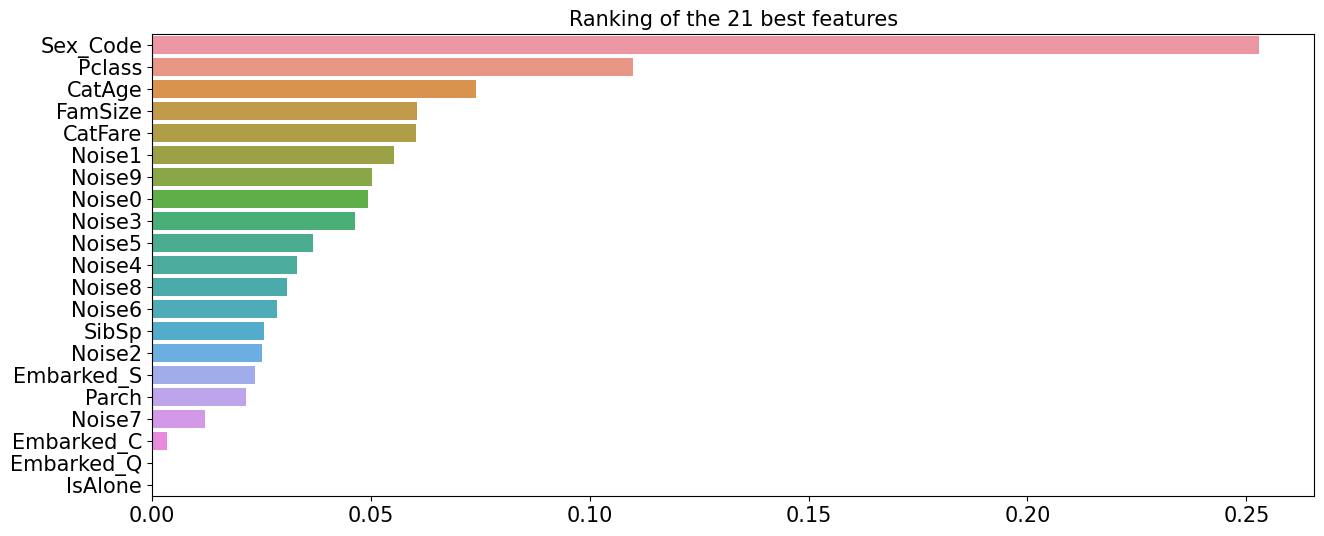

Training Accuracy is:  1.0
Testing Accuracy is:  0.6956521739130435


In [90]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(0)
X_with_extra = X.copy()
for i in range(10):
    noisy_array = np.random.choice(np.arange(2), 891)
    X_with_extra[f"Noise{i}"] = noisy_array

x_train, x_test, y_train, y_test = train_test_split(X_with_extra, y, test_size=0.8)

model.fit(x_train, y_train)
plot_feature_importances(x_train.columns, model.feature_importances_)

prediction_train = model.predict(x_train)
predictions_test = model.predict(x_test)

train_acc = accuracy_score(prediction_train, y_train)
test_acc = accuracy_score(predictions_test, y_test)

print("Training Accuracy is: ", train_acc)
print("Testing Accuracy is: ", test_acc)

Why does noise have a high feat import sore? And does this guarantee a higher predictive accuracy? If RFECV includes Noise, would performance increase after removing Noise?

In [91]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(x_train, y_train)

plot_features_vs_cvscore(rfecv)
max_score = np.max(rfecv.cv_results_["mean_test_score"])
print(f"Max Score: {max_score}")
rfecv.get_feature_names_out()

Max Score: 0.8146031746031746


array(['Pclass', 'FamSize', 'CatAge', 'CatFare', 'Sex_Code', 'Noise0',
       'Noise1', 'Noise2', 'Noise3', 'Noise4', 'Noise5', 'Noise6',
       'Noise8', 'Noise9'], dtype=object)

Why is "Noise" ranked high in our feature importances! This means that every iteration of our RFECV likely contains this feature, since we can only remove the lowest ranked features, not the highest ranked ones! This is bonkers. We keep the important scores, and not the useful ones that contribute to the performance of our model. The model is overfitted on this noisy feature. 

In [92]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model.fit(x_train, y_train)
plot_feature_importances(x_train.columns, model.feature_importances_)

predictions = model.predict(x_test)
prediction_train = model.predict(x_train)

train_acc = accuracy_score(prediction_train, y_train)
test_acc = accuracy_score(predictions, y_test)

print("Training Accuracy is: ", train_acc)
print("Testing Accuracy is: ", test_acc)

Training Accuracy is:  0.8932584269662921
Testing Accuracy is:  0.8156424581005587


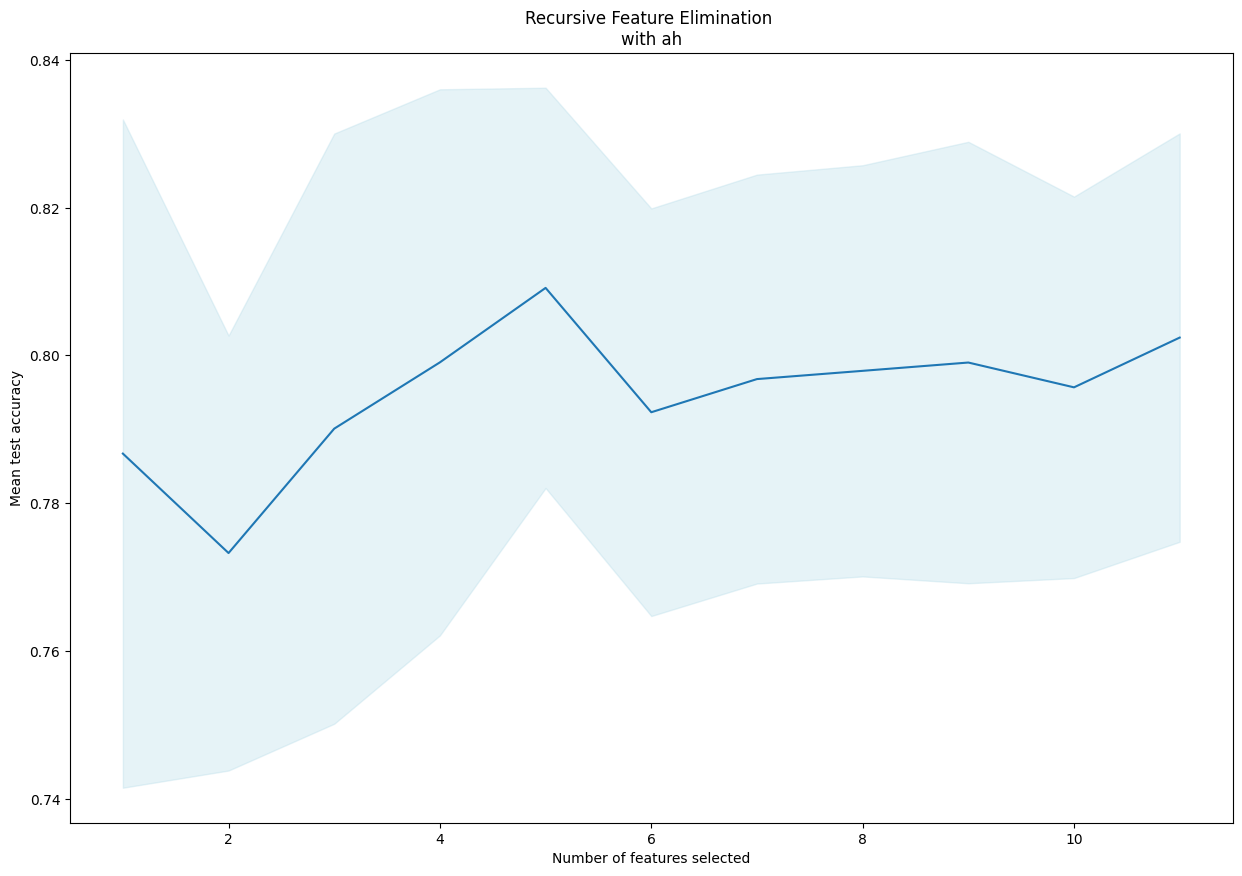

Max Score: 0.8091519678614023


array(['Pclass', 'FamSize', 'CatAge', 'CatFare', 'Sex_Code'], dtype=object)

In [94]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(x_train, y_train)

plot_features_vs_cvscore(rfecv)
max_score = np.max(rfecv.cv_results_["mean_test_score"])
print(f"Max Score: {max_score}")
rfecv.get_feature_names_out()

Sunshine and rainbows.

<a id="9"></a>
### Warning 2: Increase Cardinality spells Doom

During our data transformations, we had categorised our continuous variables Age and Fare. Some may argue that this reduces the information provided by these variables and so and so. Let's see what happens if we dont categorise them!

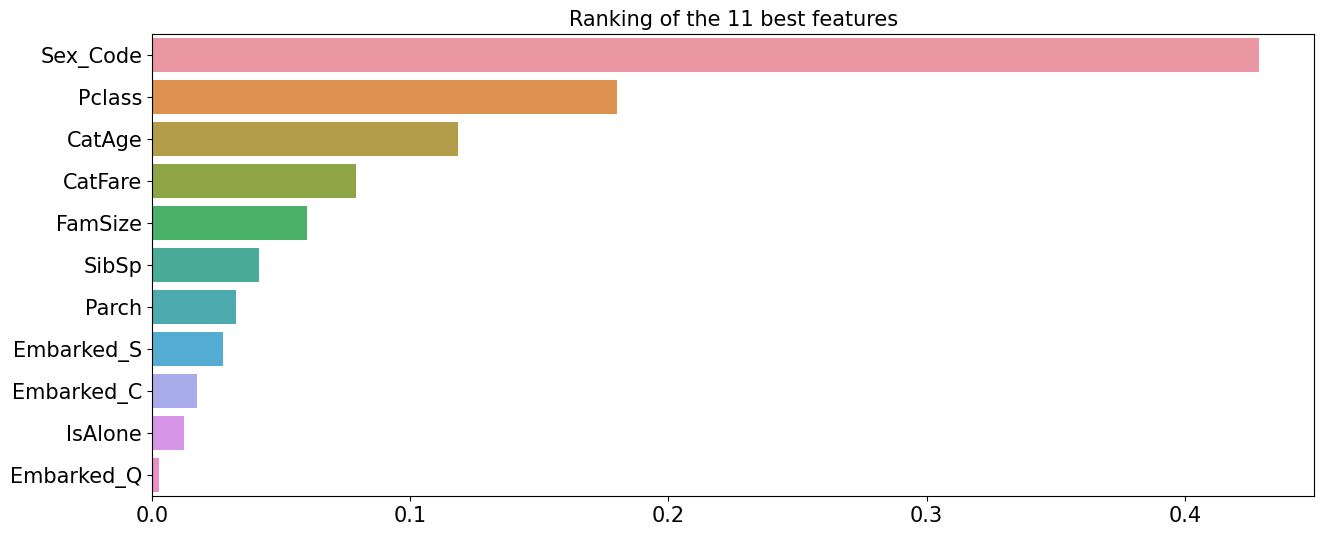

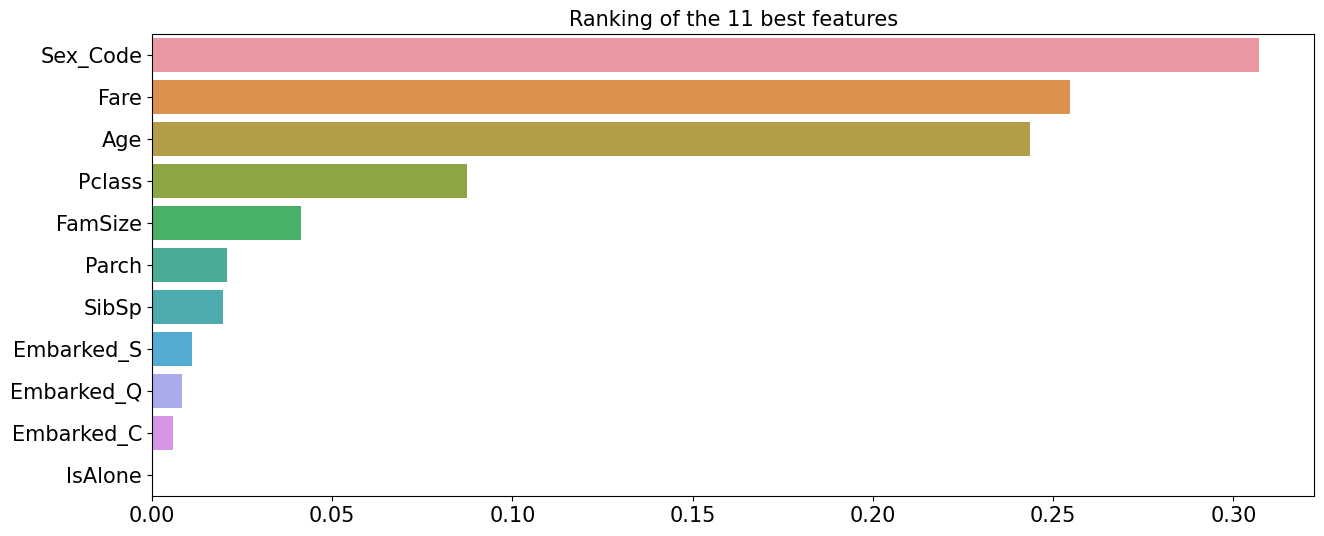

In [44]:
# Defining independent and target variables
X_cont = train[["Pclass", "SibSp", "FamSize", "IsAlone", "Parch", "Age", "Fare",
         "Sex_Code", "Embarked_C", "Embarked_Q", "Embarked_S"]]

model.fit(X, y)
plot_feature_importances(X.columns, model.feature_importances_)
model.fit(X_cont, y)
plot_feature_importances(X_cont.columns, model.feature_importances_)

The feature importance of "Fare" and "Age" has risen considerably. One hypothesis could be that by binning/categorising our continuous variables, we have lost a lot of information and made them less important in the model? Let us check their RFECV scores.

In [13]:
from sklearn.model_selection import cross_val_score
print("With Binning:", cross_val_score(model, X, y, cv=cv_split, scoring='accuracy').mean())
print("Without Binning:", cross_val_score(model, X_cont, y, cv=cv_split, scoring='accuracy').mean())

With Binning: 0.802422948967422
Without Binning: 0.7777289561232816


**Takeaway**

The CV score has dropped a fair bit without binning our continuous variables. And with a shift in feature importance rankings, there will also be a changein the selected features by RFECV, making it not as reliable.

This is not because it is the more useful feature to predict the target variable, but simply because it's a continuous variable, increasing its cardinality to a large extent and boosting its feature importance.

Let us try adding a completely non-correlated feature to our data and analyse its feature importance scores.

We can vary the cardinality of our added "Noise" variable, by changing the options for random integers it can take. We plot this below to understand the bias feature importances provides to high cardinality features: (Averaged over multiple noise RNG seeds)

In [15]:
cardinality = 50
num_seeds = 10  # Choose the number of seeds you want to average over

# Initialize a list to store feature importances for each seed
average_noise_feat_importances = []

for seed in range(num_seeds):
    np.random.seed(seed)  # Set a different seed for each iteration
    noise_feat_importances = []

    for i in range(1, cardinality):
        noisy_array = np.random.choice(np.arange(i), 891)
        X_with_extra = X.copy()
        X_with_extra["Noise"] = noisy_array
        model.fit(X_with_extra, y)
        noise_index = np.argmax(X_with_extra.columns == 'Noise')
        noise_feat_importances.append(model.feature_importances_[noise_index])

    # Store feature importances for the current seed
    average_noise_feat_importances.append(noise_feat_importances)

# Convert the list of lists into a NumPy array for easier manipulation
average_noise_feat_importances = np.array(average_noise_feat_importances)

# Calculate the mean and standard deviation across seeds for each cardinality
mean_feat_importances = np.mean(average_noise_feat_importances, axis=0)
std_feat_importances = np.std(average_noise_feat_importances, axis=0)

# Plot the mean with error bars representing the standard deviation
plt.plot(np.arange(1, cardinality), mean_feat_importances)
plt.fill_between(np.arange(1, cardinality), 
                     mean_feat_importances - std_feat_importances, 
                     mean_feat_importances + std_feat_importances, 
                     alpha=0.3, 
                     color="lightblue")
plt.xlabel("Cardinality")
plt.ylabel("Feature Importance of Noise")
plt.show()

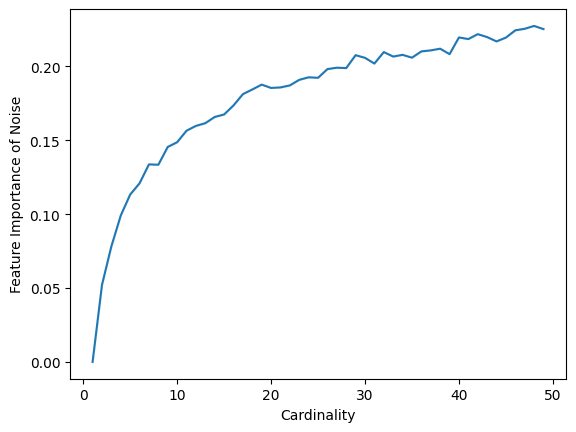

In [53]:
cardinality = 50
num_seeds = 1  # Choose the number of seeds you want to average over

# Initialize a list to store feature importances for each seed
average_noise_feat_importances = []

for seed in range(num_seeds):
    np.random.seed(seed)  # Set a different seed for each iteration
    noise_feat_importances = []

    for i in range(1, cardinality):
        noisy_array = np.random.choice(np.arange(i), len(X2))
        X_with_extra = X2.copy()
        X_with_extra["Noise"] = noisy_array
        model.fit(X_with_extra, y2)
        noise_index = np.argmax(X_with_extra.columns == 'Noise')
        noise_feat_importances.append(model.feature_importances_[noise_index])

    # Store feature importances for the current seed
    average_noise_feat_importances.append(noise_feat_importances)

# Convert the list of lists into a NumPy array for easier manipulation
average_noise_feat_importances = np.array(average_noise_feat_importances)

# Calculate the mean and standard deviation across seeds for each cardinality
mean_feat_importances = np.mean(average_noise_feat_importances, axis=0)
std_feat_importances = np.std(average_noise_feat_importances, axis=0)

# Plot the mean with error bars representing the standard deviation
plt.plot(np.arange(1, cardinality), mean_feat_importances)
plt.fill_between(np.arange(1, cardinality), 
                     mean_feat_importances - std_feat_importances, 
                     mean_feat_importances + std_feat_importances, 
                     alpha=0.3, 
                     color="lightblue")
plt.xlabel("Cardinality")
plt.ylabel("Feature Importance of Noise")
plt.show()

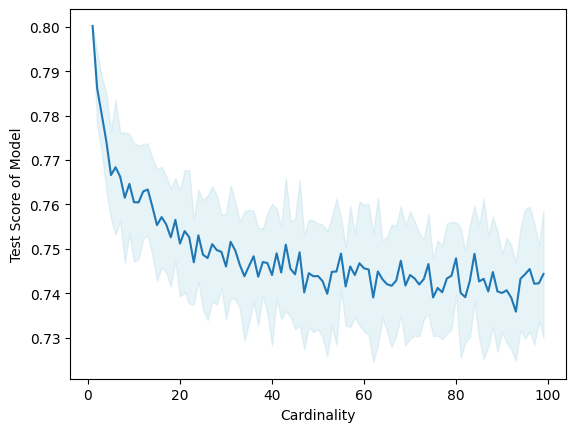

In [18]:
from sklearn.model_selection import cross_val_score

cardinality = 100
num_seeds = 20

# Initialize a list to store test scores for each seed
average_noise_scores = []

for seed in range(num_seeds):
    np.random.seed(seed)  # Set a different seed for each iteration
    noise_scores = []

    for i in range(1, cardinality):
        noisy_array = np.random.choice(np.arange(i), 891)
        X_with_extra = X.copy()
        X_with_extra["Noise"] = noisy_array
        model.fit(X_with_extra, y)
        cv_scores = cross_val_score(model, X_with_extra, y, cv=cv_split, scoring='accuracy')
        noise_scores.append(cv_scores.mean())

    # Store test scores for the current seed
    average_noise_scores.append(noise_scores)

# Convert the list of lists into a NumPy array for easier manipulation
average_noise_scores = np.array(average_noise_scores)

# Calculate the mean and standard deviation across seeds for each cardinality
mean_scores = np.mean(average_noise_scores, axis=0)
std_scores = np.std(average_noise_scores, axis=0)

# Plot the mean with error bars representing the standard deviation
plt.plot(np.arange(1, cardinality), mean_scores)
plt.fill_between(np.arange(1, cardinality), 
                     mean_scores - std_scores, 
                     mean_scores + std_scores, 
                     alpha=0.3, 
                     color="lightblue")
plt.xlabel("Cardinality")
plt.ylabel("Test Score of Model")
plt.show()

In [29]:
cardinality = 20
num_seeds = 5

# Initialize a list to store test scores for each seed
average_noise_scores = []

for seed in range(num_seeds):
    np.random.seed(seed)  # Set a different seed for each iteration
    noise_scores = []

    for i in range(1, cardinality):
        noisy_array = np.random.choice(np.arange(i), len(X2))
        X_with_extra = X2.copy()
        X_with_extra["Noise"] = noisy_array
        model.fit(X_with_extra, y2)
        cv_scores = cross_val_score(model, X_with_extra, y2, cv=cv_split, scoring='accuracy')
        noise_scores.append(cv_scores.mean())

    # Store test scores for the current seed
    average_noise_scores.append(noise_scores)

# Convert the list of lists into a NumPy array for easier manipulation
average_noise_scores = np.array(average_noise_scores)

# Calculate the mean and standard deviation across seeds for each cardinality
mean_scores = np.mean(average_noise_scores, axis=0)
std_scores = np.std(average_noise_scores, axis=0)

# Plot the mean with error bars representing the standard deviation
plt.plot(np.arange(1, cardinality), mean_scores)
plt.fill_between(np.arange(1, cardinality), 
                     mean_scores - std_scores, 
                     mean_scores + std_scores, 
                     alpha=0.3, 
                     color="lightblue")
plt.xlabel("Cardinality")
plt.ylabel("Test Score of Model")
plt.show()

KeyboardInterrupt: 

Large dataset version:





Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. It solves these two warnings so may be something to consider.

Note: Noise is not that important for XGBoost.

This example does a good investigation of this same warnings, and show how an alternative feature ranking called permutation importance solves these two warnings. It has no bias to high cardinality features, and due to being calculated on a test set too, works on an overfitting model: 
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

<a id="6"></a>
# Correlated Features

What if we have two duplicated features? Will RFECV choose both? Choose one? Choose neither? This once again may differ depending on the algorithm you are working with. We will explain this with respect to Decision Tree models. In the docstring for the random_state parameter:

>**random_state : *int, RandomState instance or None, default=None*** </br>
> Controls the randomness of the estimator. The features are always randomly permuted at each split, even if splitter is set to "best". When max_features < n_features, the algorithm will select max_features at random at each split before finding the best split among them. **But the best found split may vary across different runs, even if max_features=n_features. That is the case, if the improvement of the criterion is identical for several splits and one split has to be selected at random.**


Let's dupe our first feature:

In [8]:
X_with_dup = X.copy()
X_with_dup["Duplicate"] = X_with_dup["Sex_Code"]
X_with_dup

Pclass  SibSp  FamSize  IsAlone  Parch  CatAge  CatFare  Sex_Code  \
0         3      1        2        0      0       1        0         1   
1         1      1        2        0      0       2        4         0   
2         3      0        1        1      0       2        1         0   
3         1      1        2        0      0       2        4         0   
4         3      0        1        1      0       2        1         1   
..      ...    ...      ...      ...    ...     ...      ...       ...   
886       2      0        1        1      0       2        2         1   
887       1      0        1        1      0       1        3         0   
888       3      1        4        0      2       2        3         0   
889       1      0        1        1      0       2        3         1   
890       3      0        1        1      0       2        0         1   

     Embarked_C  Embarked_Q  Embarked_S  Duplicate  
0             0           0           1          1  
1             1           0           0          0  
2             0           0           1          0  
3             0           0           1          0  
4             0           0           1          1  
..          ...         ...         ...        ...  
886           0           0           1          1  
887           0           0           1          0  
888           0           0           1          0  
889           1           0           0          1  
890           0           1           0          1  

[891 rows x 12 columns]

**Pearson Correlation Heatmap**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows:

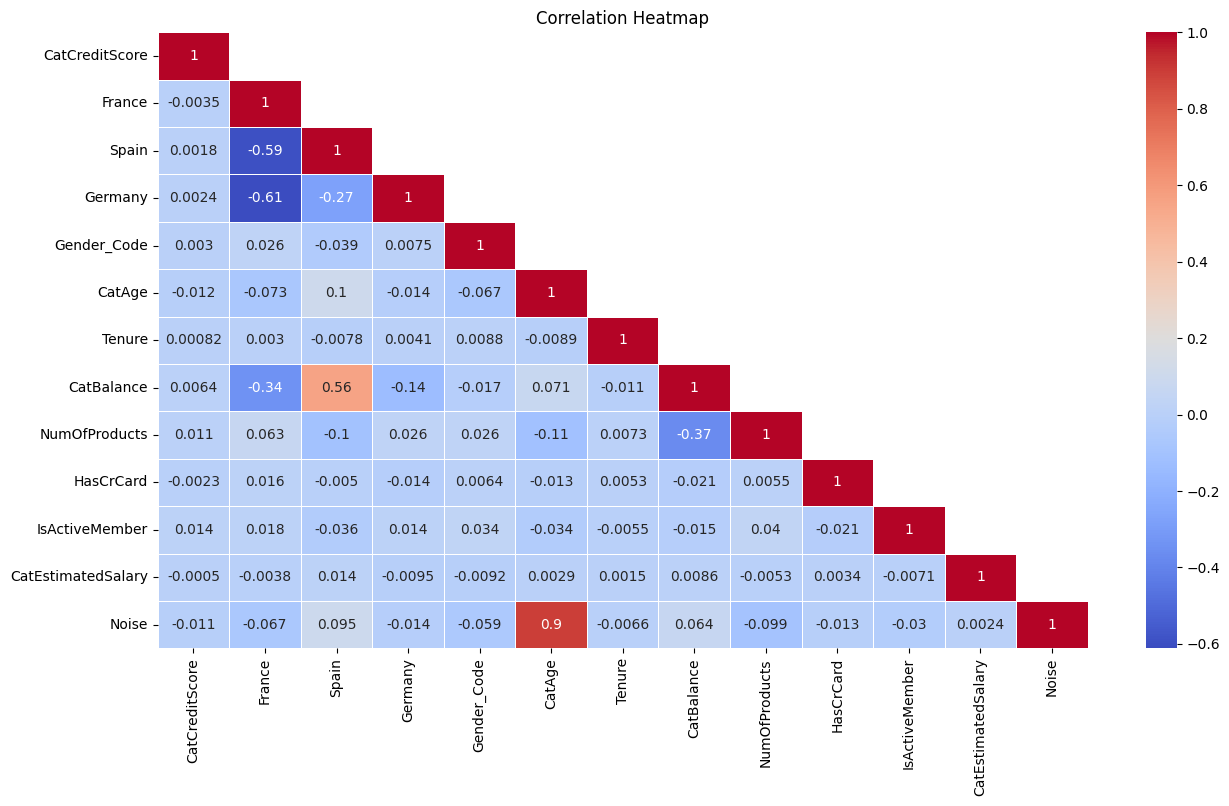

In [65]:
def plot_corr_map(data):    
    corr_matrix = data.corr()
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask, k=1)] = True

    plt.figure(figsize=(15, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, linewidths=.5)
    plt.title("Correlation Heatmap")
    plt.show()

plot_corr_map(X_with_dup)

**Takeaway from the Plots**

One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. 

In [10]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(X_with_dup, y)

print(list(rfecv.get_feature_names_out()))
print(f'Score: {np.max(rfecv.cv_results_["mean_test_score"])}')

['Pclass', 'FamSize', 'CatAge', 'CatFare', 'Sex_Code']
Score: 0.8091519678614023


In [19]:
model.fit(X_with_dup, y)
plot_feature_importances(X_with_dup.columns, model.feature_importances_)

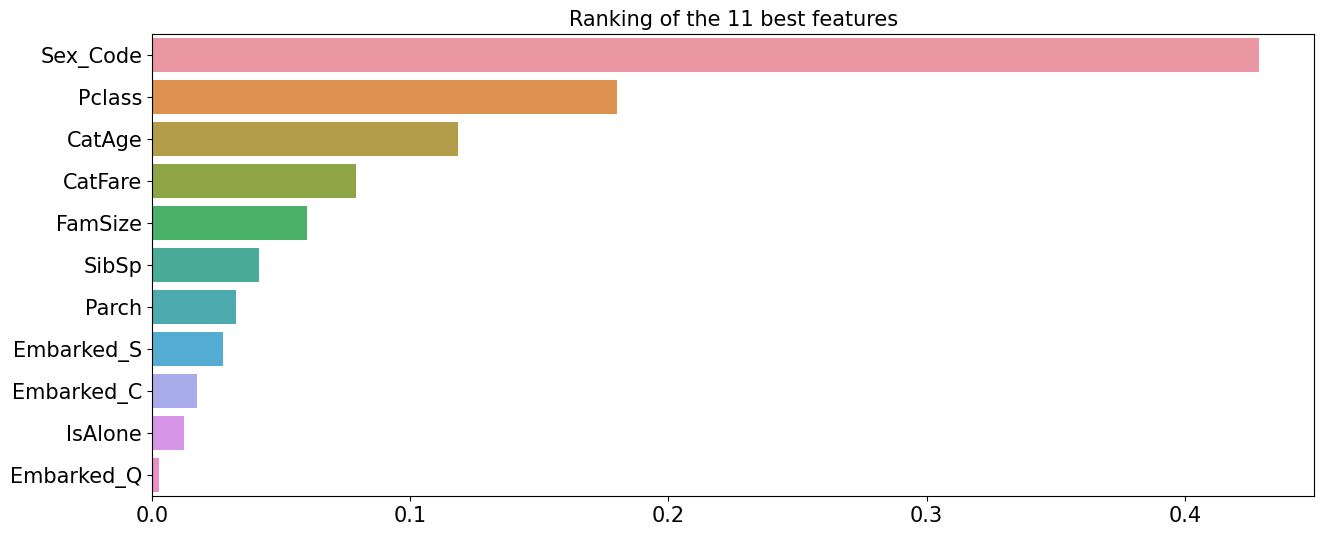

In [16]:
model.fit(X, y)
plot_feature_importances(X.columns, model.feature_importances_)

However, let us understand the relationship between correlation and feature importance. Our Duplicate feature has a correlation of 1 with "Sex_Code", and thus has feature importance 0. 

Note: This depends on how feature importances are calculated of course. For example, in RandomForests since they are a collection of decision trees with a random subset of features, some trees may have only contained Duplicate but not Sex_Code. Thus, Duplicate would have a non-zero feature importance.

NOTE: Interestingly, the feature importance of other variables has changed slightly after adding our duplicate feature, despite it not appearing in a single split. This is actually because since X and X_with_dup are different datasets, the model fit with both have a different random_state RNG. Therefore, tied features splits may be such that model fitted with X chooses Feature A in the split, and model fitted with X_with_dup chooses Feature B in the tied split. This could be double checked by running DecisionTrees with several random_state to check if your model is stable.

How would this change for a feature highly correlated, but maybe not exactly a duplicate?

In [20]:
def create_highly_correlated_column(existing_column, correlation_coefficient, seed=0):
    """Create a highly correlated feature with an existing feature of equal cardinality."""
    
    np.random.seed(seed)
    noisy_column = existing_column.copy()
    noise_values = noisy_column.value_counts(normalize=True).index
    distribution = noisy_column.value_counts(normalize=True).tolist()
    noisy_column = noisy_column.apply(lambda x: np.random.choice(noise_values, p=distribution) 
                                      if np.random.rand() >= correlation_coefficient else x)

    return noisy_column

X_with_dup = X.copy()
X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup["Sex_Code"], 0.5)
X_with_dup

Pclass  SibSp  FamSize  IsAlone  Parch  CatAge  CatFare  Sex_Code  \
0         3      1        2        0      0       1        0         1   
1         1      1        2        0      0       2        4         0   
2         3      0        1        1      0       2        1         0   
3         1      1        2        0      0       2        4         0   
4         3      0        1        1      0       2        1         1   
..      ...    ...      ...      ...    ...     ...      ...       ...   
886       2      0        1        1      0       2        2         1   
887       1      0        1        1      0       1        3         0   
888       3      1        4        0      2       2        3         0   
889       1      0        1        1      0       2        3         1   
890       3      0        1        1      0       2        0         1   

     Embarked_C  Embarked_Q  Embarked_S  Noise  
0             0           0           1      0  
1             1           0           0      1  
2             0           0           1      0  
3             0           0           1      1  
4             0           0           1      0  
..          ...         ...         ...    ...  
886           0           0           1      0  
887           0           0           1      0  
888           0           0           1      1  
889           1           0           0      1  
890           0           1           0      1  

[891 rows x 12 columns]

In [7]:
def plot_correlation_vs_correlation(X, y, copy_feature, num_seeds=50, mesh=101):
    X_with_dup = X.copy()
    x = np.linspace(0, 1, mesh)
    average_correlation = []

    for seed in range(num_seeds):
        correlation_coeffs = []
        for corr in x:
            X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup[copy_feature], corr, seed=seed)
            correlation_coeffs.append(X_with_dup.corr()[copy_feature]["Noise"])

        average_correlation.append(correlation_coeffs)

    # Convert the list of lists into a NumPy array for easier manipulation
    average_correlation = np.array(average_correlation)

    # Calculate the mean and standard deviation across seeds for each cardinality
    mean_correlation = np.mean(average_correlation, axis=0)
    std_correlation = np.std(average_correlation, axis=0)

    # Plot the mean with error bars representing the standard deviation
    plt.plot(x, mean_correlation)
    plt.fill_between(x, 
                     mean_correlation - std_correlation, 
                     mean_correlation + std_correlation, 
                     alpha=0.3, 
                     color="lightblue")
    plt.title(f"Correlation of {copy_feature}")
    plt.xlabel("Our Function's Correlation")
    plt.ylabel("Correlation")
    plt.show()

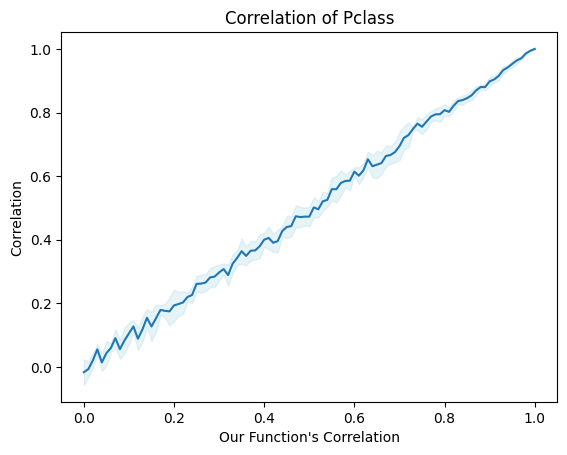

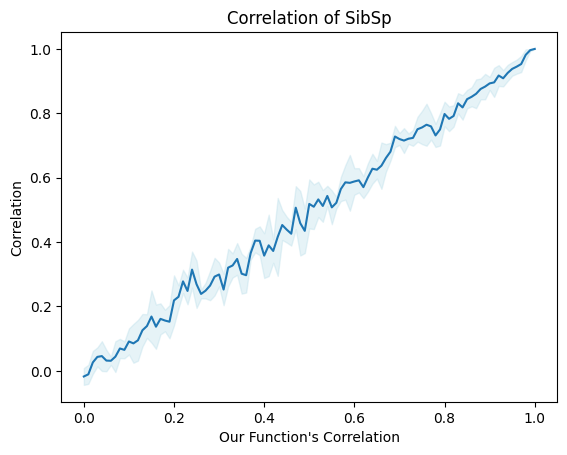

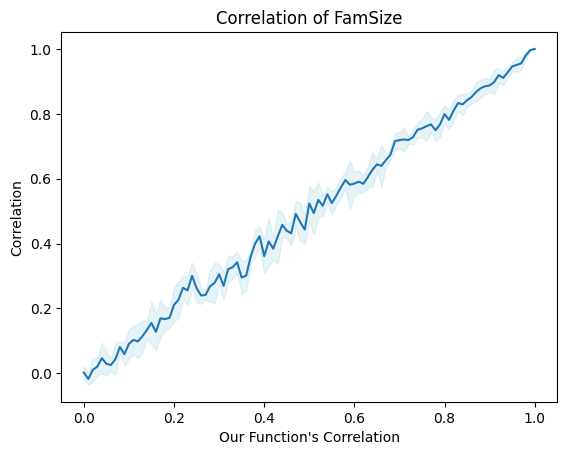

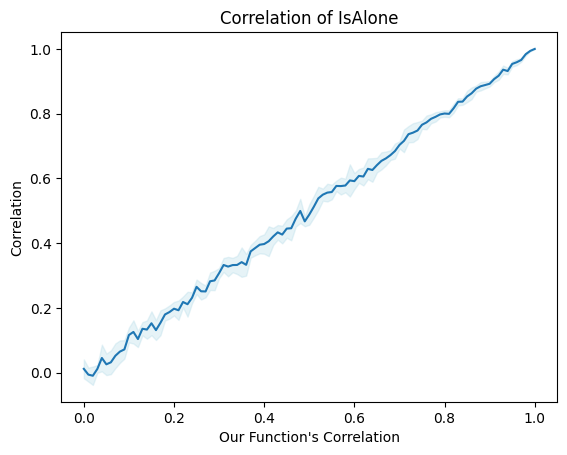

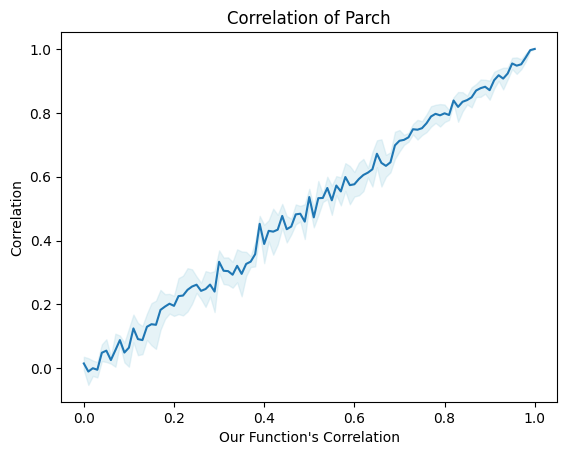

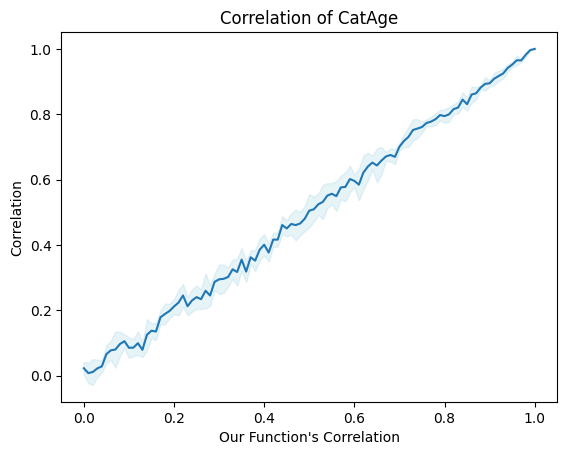

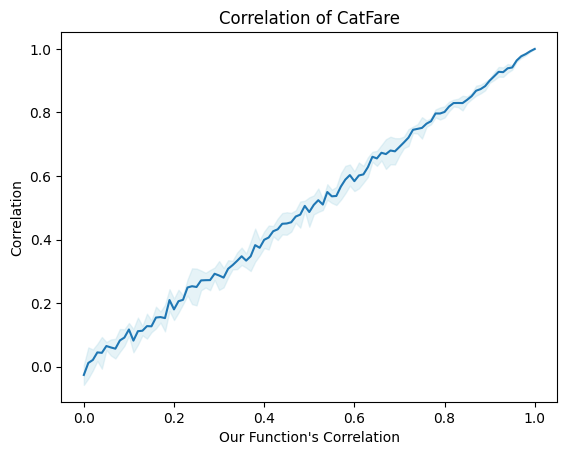

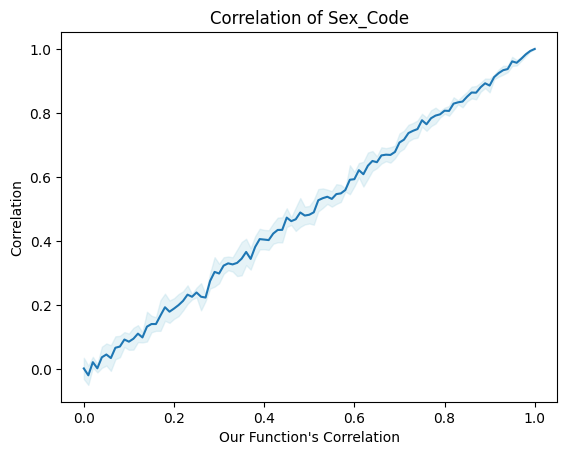

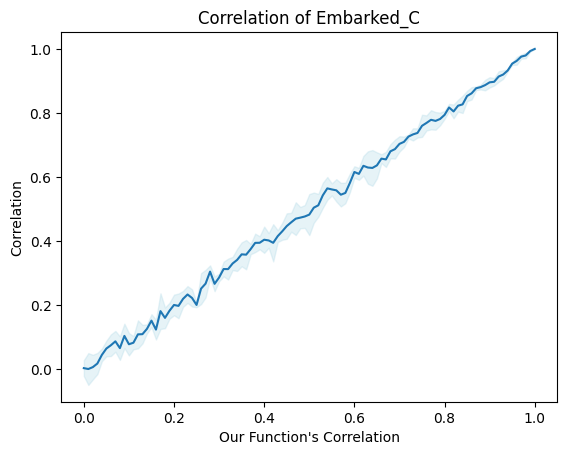

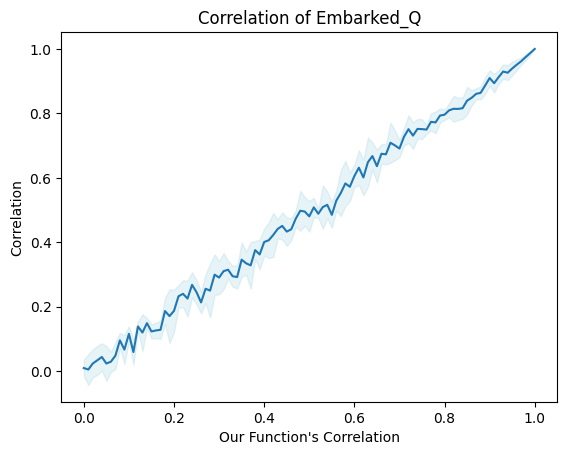

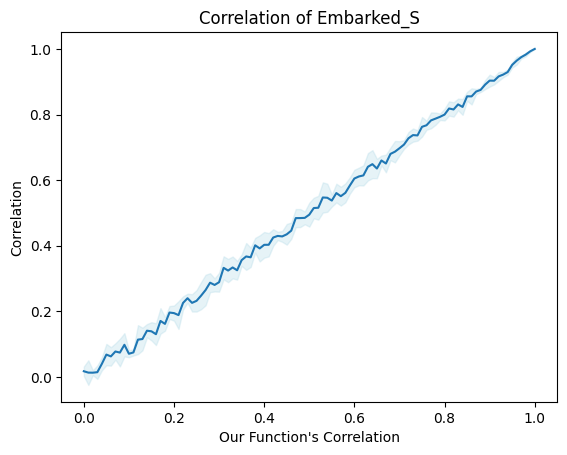

In [234]:
for var in X.columns:
    plot_correlation_vs_correlation(X, y, var, num_seeds=5)

The results show that our function is a very good measure for the correlation.
___

In [236]:
def plot_correlation_vs_importances(model, X, y, copy_feature, cutoff=0.1, num_seeds=50, x = np.linspace(0, 0.9, mesh)):
    X_with_dup = X.copy()
    
    average_importances = []

    for seed in range(num_seeds):
        correlated_noise_importances = []
        for corr in x:
            X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup[copy_feature], corr, seed=seed)
            model.fit(X_with_dup, y)
                        # Taking a reasonable assumption that above cutoff means all feat importance has gone to correlated variable
            if model.feature_importances_[-1] < cutoff:
                correlated_noise_importances.append(model.feature_importances_[X_with_dup.columns.get_loc("Noise")])
            else:
                correlated_noise_importances.append(correlated_noise_importances[-1])
        average_importances.append(correlated_noise_importances)

    # Convert the list of lists into a NumPy array for easier manipulation
    average_importances = np.array(average_importances)

    # Calculate the mean and standard deviation across seeds for each cardinality
    mean_importances = np.mean(average_importances, axis=0)
    std_importances = np.std(average_importances, axis=0)

    # Plot the mean with error bars representing the standard deviation
    plt.plot(x, mean_importances)
    plt.fill_between(x, 
                     mean_importances - std_importances, 
                     mean_importances + std_importances, 
                     alpha=0.3, 
                     color="lightblue")
    plt.title(f"Correlated {copy_feature} feature importance")
    plt.xlabel("Correlation")
    plt.ylabel("Average Feature Importances")
    plt.show()

In [140]:
def plot_correlation_vs_importances2(X, y, copy_feature, num_seeds=50, x=np.linspace(0, 1, 101)):
    X_with_dup = X.copy()
    average_importances = []
    average_importances2 = []

    for seed in range(num_seeds):
        correlated_noise_importances = []
        correlated_noise_importances2 = []
        model = DecisionTreeClassifier(random_state=seed)
        for corr in x:
            X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup[copy_feature], corr, seed=seed)
            model.fit(X_with_dup, y)
            correlated_noise_importances.append(model.feature_importances_[X_with_dup.columns.get_loc("Noise")])
            correlated_noise_importances2.append(model.feature_importances_[X_with_dup.columns.get_loc(copy_feature)])
        average_importances.append(correlated_noise_importances)
        average_importances2.append(correlated_noise_importances2)

    # Convert the list of lists into a NumPy array for easier manipulation
    average_importances = np.array(average_importances)
    average_importances2 = np.array(average_importances2)

    # Calculate the mean and standard deviation across seeds for each cardinality
    mean_importances = np.mean(average_importances, axis=0)
    std_importances = np.std(average_importances, axis=0)

    mean_importances2 = np.mean(average_importances2, axis=0)
    std_importances2 = np.std(average_importances2, axis=0)

    # Plot the mean with error bars representing the standard deviation
    plt.plot(x, mean_importances)
    plt.fill_between(x, 
                     mean_importances - std_importances, 
                     mean_importances + std_importances, 
                     alpha=0.3, 
                     color="lightblue")
    plt.plot(x, mean_importances2)
    plt.fill_between(x, 
                     mean_importances2 - std_importances2, 
                     mean_importances2 + std_importances2, 
                     alpha=0.3, 
                     color="orange")
    plt.title(f"Correlated {copy_feature} feature importance")
    plt.xlabel("Correlation")
    plt.ylabel("Average Feature Importances")
    plt.show()

Since Pure noise (Corr=0) is higher than half these variables, that indicates our model is overfitting. It thinks noise is bettter than other variables. Thats why 

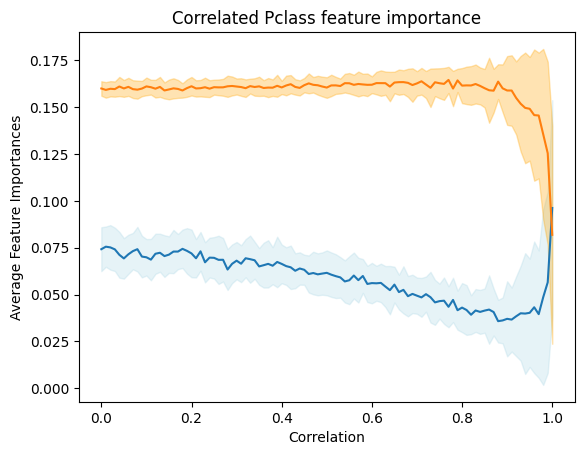

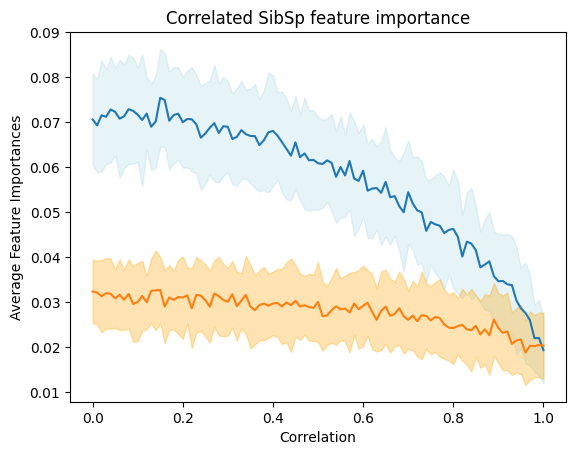

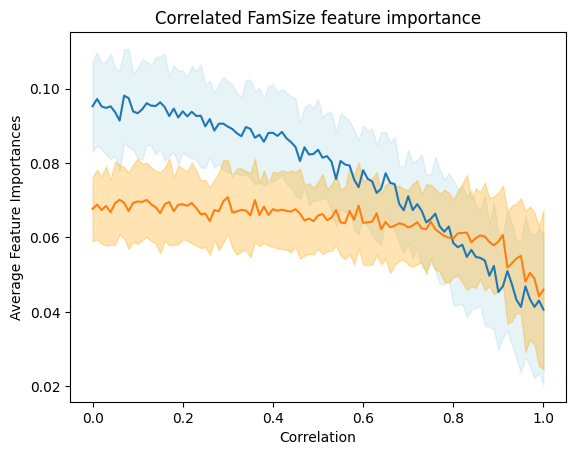

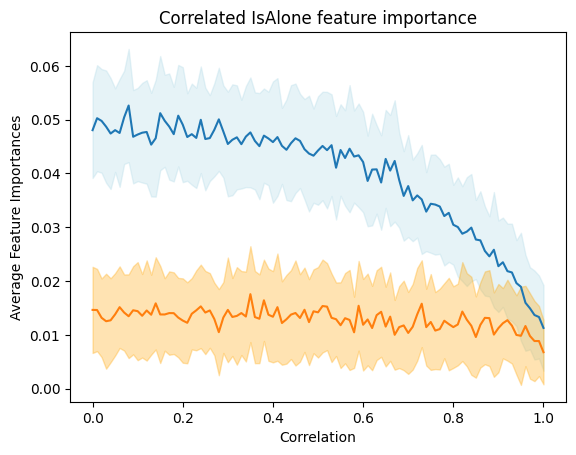

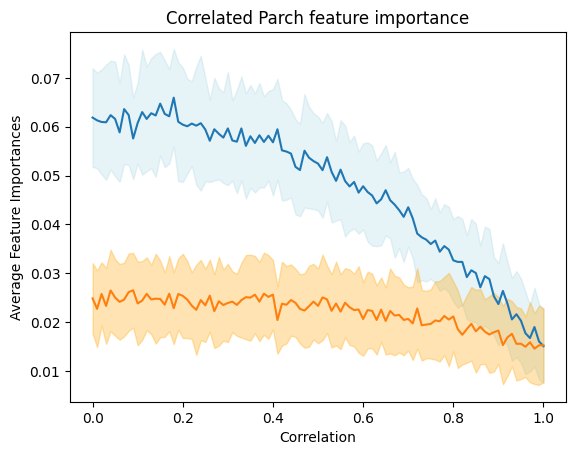

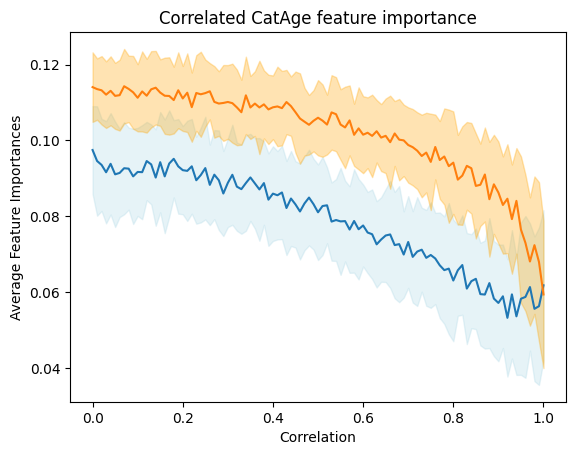

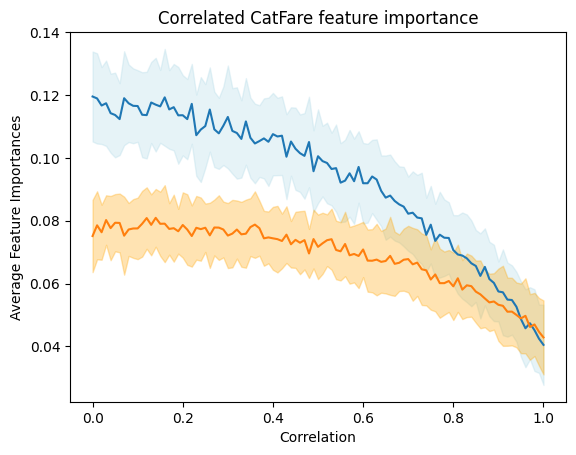

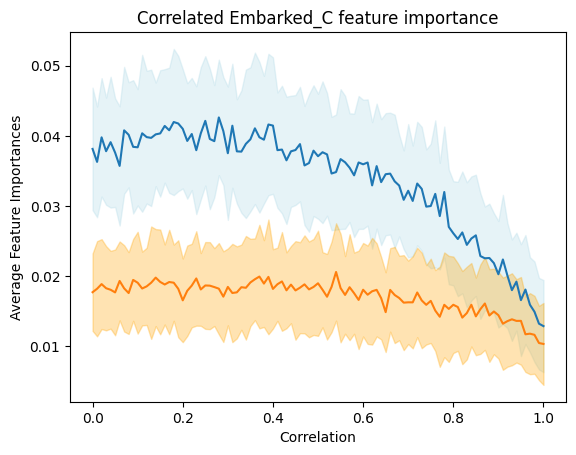

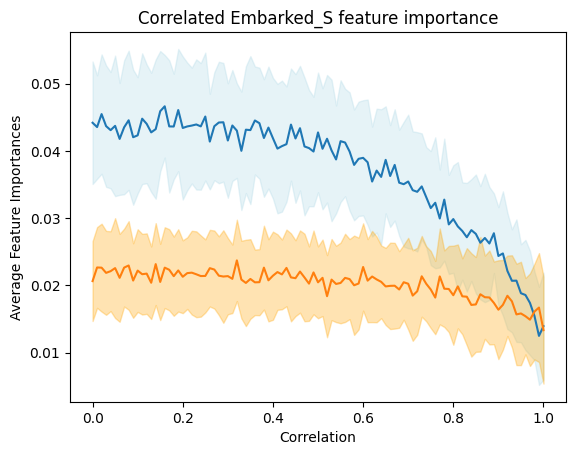

In [11]:
for var in X.columns:
    plot_correlation_vs_importances2(X, y, copy_feature=var, num_seeds=50)

In [237]:
plot_correlation_vs_importances(model, X, y, copy_feature="Sex_Code", num_seeds=20)

**Observations**

Generally for duplicate features, one will have a high feature importance and one has a low feat importance. One will get removed in RFECV since while removing the feat importance of original will increase. However, for high correlation, the tie will topside one feature importance. Sex_Code has only a singular split (the root node), so its duplicate feature has no importance. Fare has many many splits, so its duplicate feature is chosen half the time and importance is equally distributed.

In [7]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(X, y)

print(list(rfecv.get_feature_names_out()))
print(f'Score: {np.max(rfecv.cv_results_["mean_test_score"])}')

['Pclass', 'FamSize', 'CatAge', 'CatFare', 'Sex_Code']
Score: 0.8091519678614023


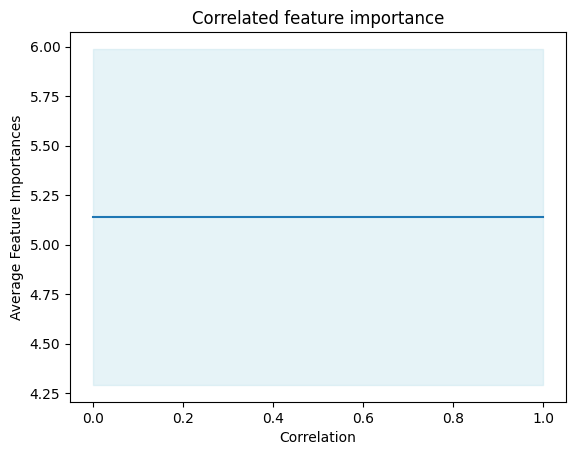

In [28]:
X_with_dup = X.copy()
x = np.linspace(0, 1, 11)
average_importances = []

for seed in range(50):
    correlated_noise_importances = []
    for corr in x:
        model=DecisionTreeClassifier(random_state=seed)

        rfecv = RFECV(
            estimator=model,
            step=1,
            cv=cv_split,
            scoring="accuracy",
            n_jobs=-1,
        )
        
        rfecv.fit(X, y)
        correlated_noise_importances.append(rfecv.n_features_)
    average_importances.append(correlated_noise_importances)

# Convert the list of lists into a NumPy array for easier manipulation
average_importances = np.array(average_importances)

# Calculate the mean and standard deviation across seeds for each cardinality
mean_importances = np.mean(average_importances, axis=0)
std_importances = np.std(average_importances, axis=0)

# Plot the mean with error bars representing the standard deviation
plt.plot(x, mean_importances)
plt.fill_between(x, 
                 mean_importances - std_importances, 
                 mean_importances + std_importances, 
                 alpha=0.3, 
                 color="lightblue")
plt.title(f"Correlated feature importance")
plt.xlabel("Correlation")
plt.ylabel("Average Feature Importances")
plt.show()

In [17]:
def plot_rfecv_features(X, y, copy_feature, num_seeds=50, mesh=101):
    X_with_dup = X.copy()
    x = np.linspace(0, 1, mesh)
    average_importances = []

    for seed in range(num_seeds):
        correlated_noise_importances = []
        for corr in x:
            model=DecisionTreeClassifier(random_state=0)
    
            rfecv = RFECV(
                estimator=model,
                step=1,
                cv=cv_split,
                scoring="accuracy",
                n_jobs=-1,
            )
           
            X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup[copy_feature], corr, seed=seed)
            rfecv.fit(X_with_dup, y)
            correlated_noise_importances.append(rfecv.n_features_)
        average_importances.append(correlated_noise_importances)

    # Convert the list of lists into a NumPy array for easier manipulation
    average_importances = np.array(average_importances)

    # Calculate the mean and standard deviation across seeds for each cardinality
    mean_importances = np.mean(average_importances, axis=0)
    std_importances = np.std(average_importances, axis=0)

    # Plot the mean with error bars representing the standard deviation
    plt.plot(x, mean_importances)
    plt.fill_between(x, 
                     mean_importances - std_importances, 
                     mean_importances + std_importances, 
                     alpha=0.3, 
                     color="lightblue")
    plt.title(f"Correlated feature importance")
    plt.xlabel("Correlation")
    plt.ylabel("Average Feature Importances")
    plt.show()

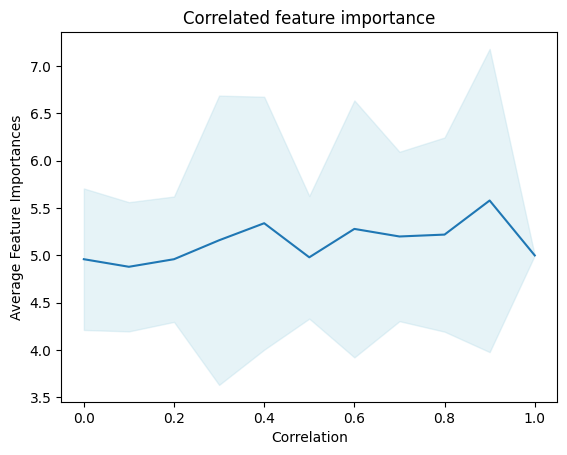

In [18]:
plot_rfecv_features(X, y, "Pclass", num_seeds=50, mesh=11)

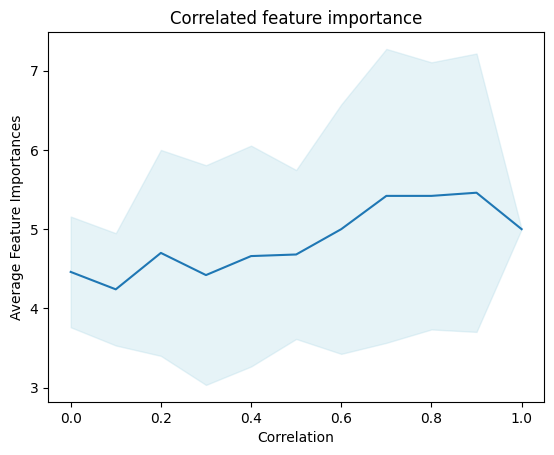

In [24]:
plot_rfecv_features(X, y, "CatAge", num_seeds=50, mesh=11)

In [23]:
plot_rfecv_features(X, y, "CatFare", num_seeds=50, mesh=11)

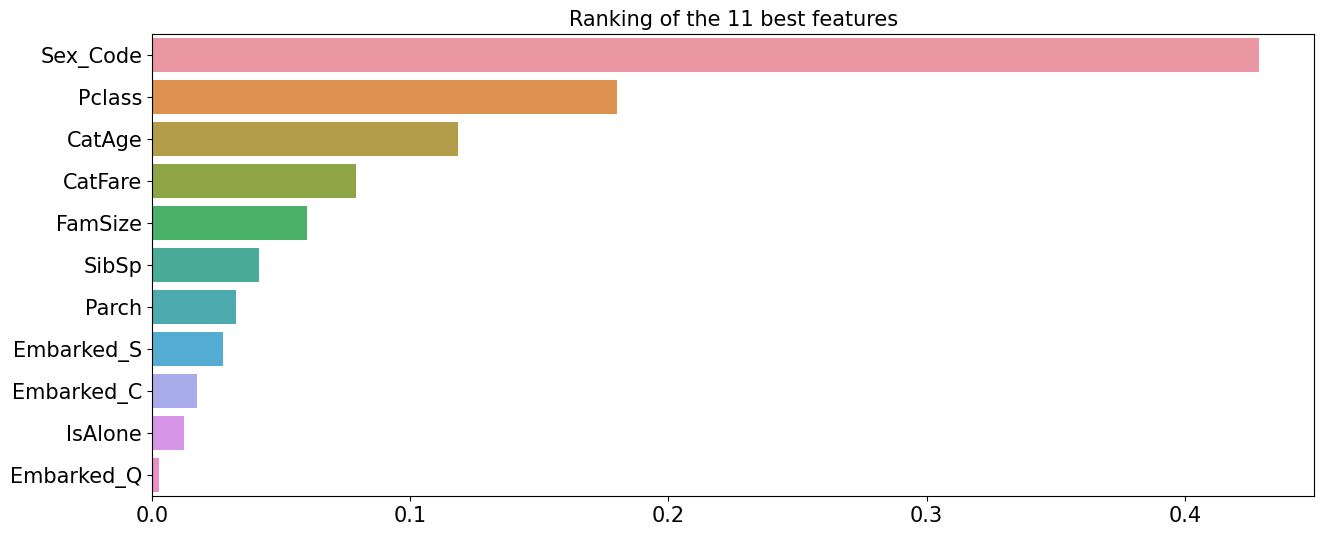

In [77]:
test_mod = DecisionTreeClassifier(random_state=seed)
X_copy = X.copy()
test_mod.fit(X_copy, y)
plot_feature_importances(X_copy.columns, test_mod.feature_importances_)

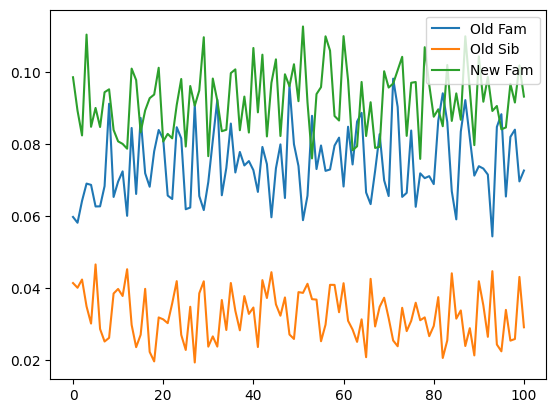

In [37]:
x=np.arange(101)
og_fam=[]
og_sib=[]
new_fam=[]
for seed in x:
    test_mod = DecisionTreeClassifier(random_state=seed)
    X_copy = X.copy()
    test_mod.fit(X_copy, y)
    og_fam.append(test_mod.feature_importances_[X_copy.columns.get_loc("FamSize")])
    og_sib.append(test_mod.feature_importances_[X_copy.columns.get_loc("SibSp")])
    X_copy.drop(columns={"SibSp"}, inplace=True)
    test_mod.fit(X_copy, y)
    new_fam.append(test_mod.feature_importances_[X_copy.columns.get_loc("FamSize")])
plt.plot(x, og_fam, label="Old Fam")
plt.plot(x, og_sib, label="Old Sib")
plt.plot(x, new_fam, label="New Fam")
plt.legend()

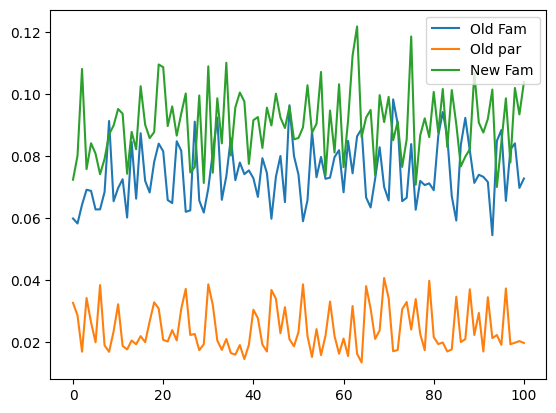

In [39]:
x=np.arange(101)
og_fam=[]
og_sib=[]
new_fam=[]
for seed in x:
    test_mod = DecisionTreeClassifier(random_state=seed)
    X_copy = X.copy()
    test_mod.fit(X_copy, y)
    og_fam.append(test_mod.feature_importances_[X_copy.columns.get_loc("FamSize")])
    og_sib.append(test_mod.feature_importances_[X_copy.columns.get_loc("Parch")])
    X_copy.drop(columns={"Parch"}, inplace=True)
    test_mod.fit(X_copy, y)
    new_fam.append(test_mod.feature_importances_[X_copy.columns.get_loc("FamSize")])
plt.plot(x, og_fam, label="Old Fam")
plt.plot(x, og_sib, label="Old par")
plt.plot(x, new_fam, label="New Fam")
plt.legend()

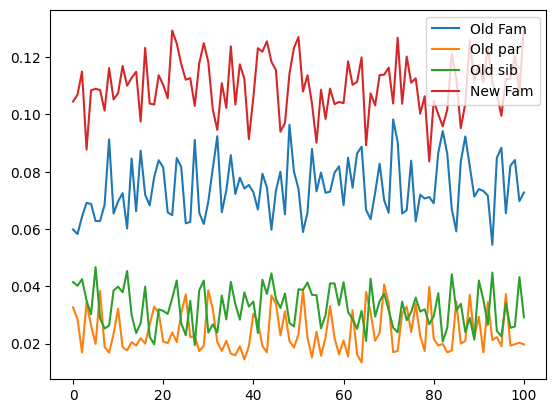

In [41]:
x=np.arange(101)
og_fam=[]
og_sib=[]
og_par=[]
new_fam=[]
for seed in x:
    test_mod = DecisionTreeClassifier(random_state=seed)
    X_copy = X.copy()
    test_mod.fit(X_copy, y)
    og_fam.append(test_mod.feature_importances_[X_copy.columns.get_loc("FamSize")])
    og_sib.append(test_mod.feature_importances_[X_copy.columns.get_loc("SibSp")])
    og_par.append(test_mod.feature_importances_[X_copy.columns.get_loc("Parch")])
    X_copy.drop(columns={"Parch", "SibSp"}, inplace=True)
    test_mod.fit(X_copy, y)
    new_fam.append(test_mod.feature_importances_[X_copy.columns.get_loc("FamSize")])
plt.plot(x, og_fam, label="Old Fam")
plt.plot(x, og_par, label="Old par")
plt.plot(x, og_sib, label="Old sib")
plt.plot(x, new_fam, label="New Fam")
plt.legend()

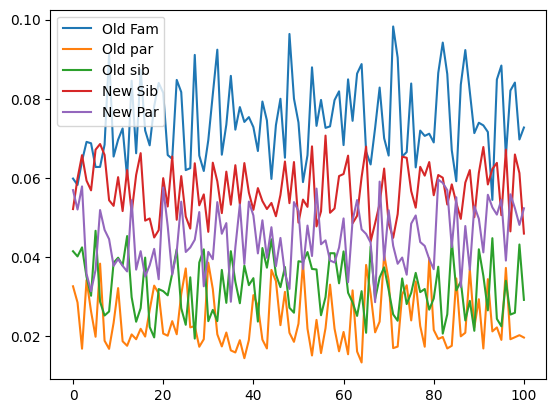

In [89]:
x=np.arange(101)
og_fam=[]
og_sib=[]
og_par=[]
new_sib=[]
new_par=[]
for seed in x:
    test_mod = DecisionTreeClassifier(random_state=seed)
    X_copy = X.copy()
    test_mod.fit(X_copy, y)
    og_fam.append(test_mod.feature_importances_[X_copy.columns.get_loc("FamSize")])
    og_sib.append(test_mod.feature_importances_[X_copy.columns.get_loc("SibSp")])
    og_par.append(test_mod.feature_importances_[X_copy.columns.get_loc("Parch")])
    X_copy.drop(columns={"FamSize"}, inplace=True)
    test_mod.fit(X_copy, y)
    new_sib.append(test_mod.feature_importances_[X_copy.columns.get_loc("SibSp")])
    new_par.append(test_mod.feature_importances_[X_copy.columns.get_loc("Parch")])
plt.plot(x, og_fam, label="Old Fam")
plt.plot(x, og_par, label="Old par")
plt.plot(x, og_sib, label="Old sib")
plt.plot(x, new_sib, label="New Sib")
plt.plot(x, new_par, label="New Par")
plt.legend()

In [97]:

rfecv = RFECV(
    estimator=test_mod,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(X, y)

print(list(rfecv.get_feature_names_out()))
print(f'Score: {np.max(rfecv.cv_results_["mean_test_score"])}')

['Pclass', 'FamSize', 'CatAge', 'CatFare', 'Sex_Code']
Score: 0.8102755633670204


In [114]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X[['Pclass', 'CatAge',"Parch", "SibSp",'CatFare', 'Sex_Code']], y).mean()

0.7890151277383717

In [96]:
test_mod=DecisionTreeClassifier(random_state=1)
X_copy = X.copy()
X_copy.drop(columns={"FamSize"}, inplace=True)

rfecv = RFECV(
    estimator=test_mod,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(X_copy, y)


print(list(rfecv.get_feature_names_out()))
print(f'Score: {np.max(rfecv.cv_results_["mean_test_score"])}')

['Pclass', 'CatAge', 'CatFare', 'Sex_Code']
Score: 0.8203941999874459


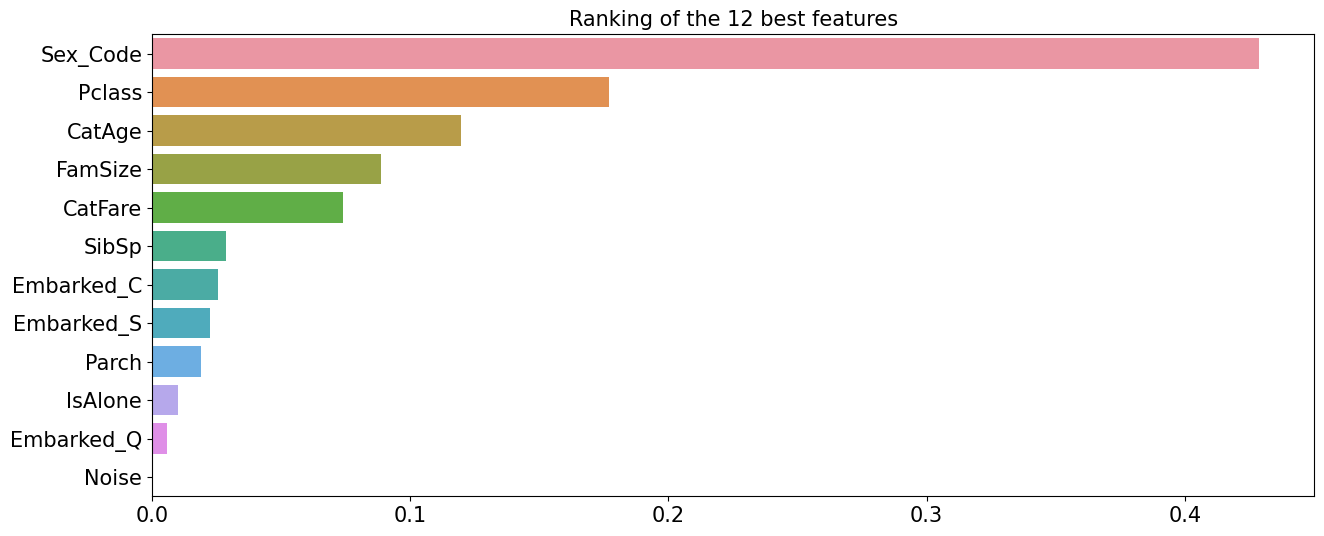

In [26]:
test_model = DecisionTreeClassifier(random_state=1)
X_with_dup = X.copy()
X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup["CatAge"], 0.95, seed=42)
test_model.fit(X_with_dup, y)
plot_feature_importances(X_with_dup.columns, test_model.feature_importances_)

In [132]:
test_model = DecisionTreeClassifier(random_state=1)
X_with_dup = X.copy()
X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup["CatAge"], 0.95, seed=42)
test_model.fit(X_with_dup, y)
plot_feature_importances(X_with_dup.columns, test_model.feature_importances_)

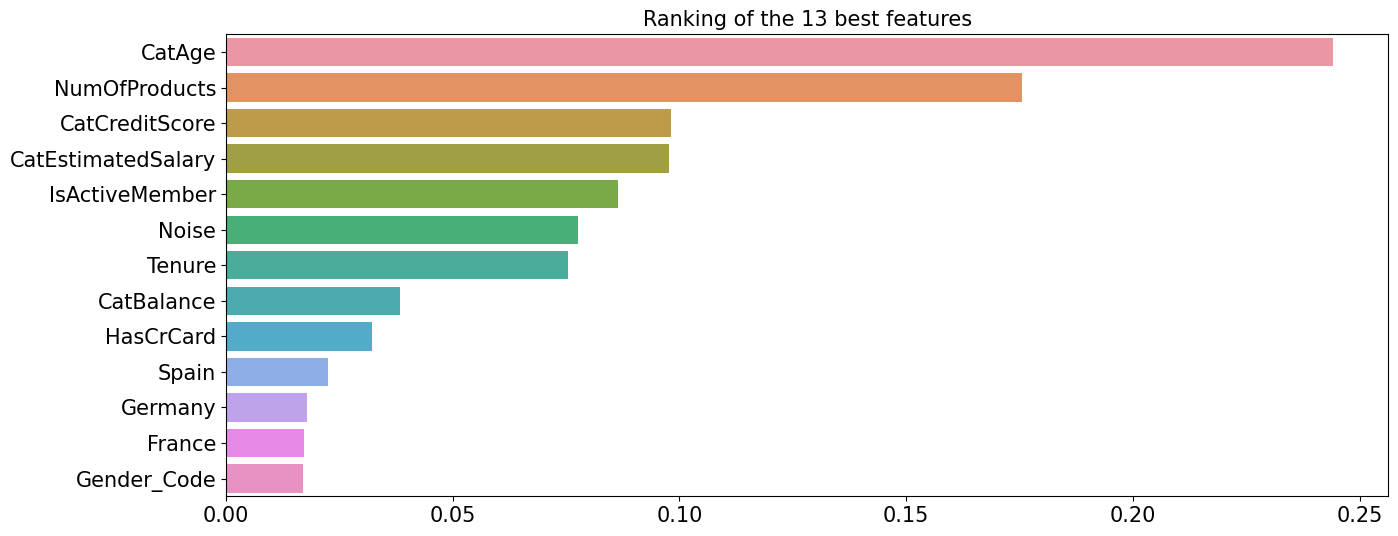

In [118]:
test_model = DecisionTreeClassifier(random_state=1)
X_with_dup = X2.copy()
X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup["Tenure"], 0.95, seed=42)
test_model.fit(X_with_dup, y2)
plot_feature_importances(X_with_dup.columns, test_model.feature_importances_)

In [22]:
scorething=[]
mesh=100
x=np.linspace(0, 1, mesh)
for corr in x:
    for seed in range(mesh):
        model=DecisionTreeClassifier(random_state=seed)

        rfecv = RFECV(
            estimator=model,
            step=1,
            cv=cv_split,
            scoring="accuracy",
            n_jobs=-1,
        )
        X_with_dup = X.copy()
        X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup["CatFare"], 0.95, seed=seed)
        rfecv.fit(X_with_dup, y)
        scorething.append(rfecv.n_features_)

x = np.linspace(0, 1, mesh)
plt.plot(x, scorething)

----

In [48]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(X_cont, y)

print(list(rfecv.get_feature_names_out()))
print(f'Score: {np.max(rfecv.cv_results_["mean_test_score"])}')

['Pclass', 'SibSp', 'FamSize', 'Parch', 'Age', 'Fare', 'Sex_Code', 'Embarked_S']
Score: 0.7900696754754881


In [18]:
X_with_dup = X_cont.copy()
X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup["Age"], 0.9, seed=42)
model.fit(X_with_dup, y)
plot_feature_importances(X_with_dup.columns, model.feature_importances_)

NameError: name 'X_cont' is not defined

In [52]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(X_with_dup, y)

print(list(rfecv.get_feature_names_out()))
print(f'Score: {np.max(rfecv.cv_results_["mean_test_score"])}')

['Pclass', 'SibSp', 'FamSize', 'IsAlone', 'Parch', 'Age', 'Fare', 'Sex_Code', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Noise']
Score: 0.7732408511706735


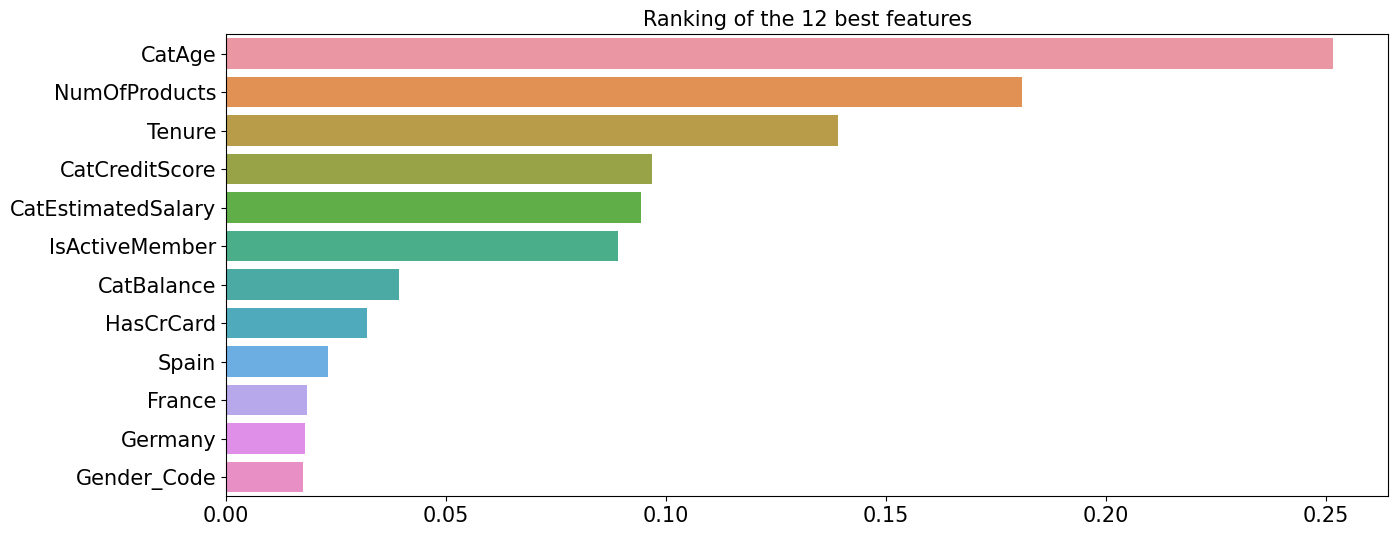

In [56]:
model.fit(X2, y2)
plot_feature_importances(X2.columns, model.feature_importances_)

In [144]:
seed=27

X_with_dup = X2.copy()
X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup["Tenure"], 0.9, seed=seed)
model.fit(X_with_dup, y2)
plot_feature_importances(X_with_dup.columns, model.feature_importances_)

In [147]:
rfecv = RFECV(
    estimator=test_mod,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(X2, y2)

print(list(rfecv.get_feature_names_out()))
print(f'Score: {np.max(rfecv.cv_results_["mean_test_score"])}')

['CatAge', 'NumOfProducts', 'IsActiveMember']
Score: 0.8479101252011603


In [148]:
X_with_dup = X2.copy()
X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup["Tenure"], 0.9, seed=seed)


rfecv = RFECV(
    estimator=test_mod,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(X_with_dup, y2)

print(list(rfecv.get_feature_names_out()))
print(f'Score: {np.max(rfecv.cv_results_["mean_test_score"])}')

['CatAge', 'NumOfProducts', 'IsActiveMember', 'Noise']
Score: 0.8479888987574833


In [151]:
for var in ["Age", "Fare"]:
    plot_correlation_vs_importances2(X_cont, y, copy_feature=var, num_seeds=20)

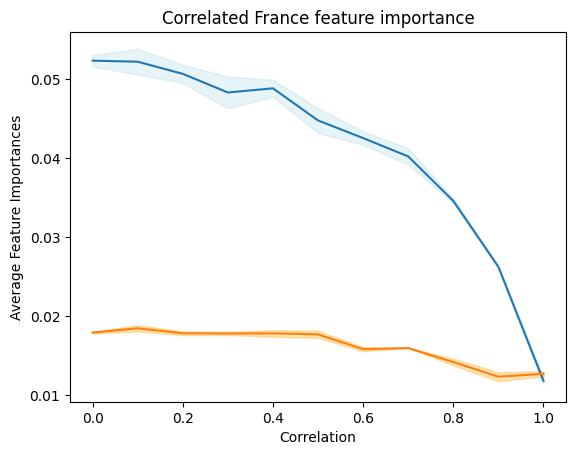

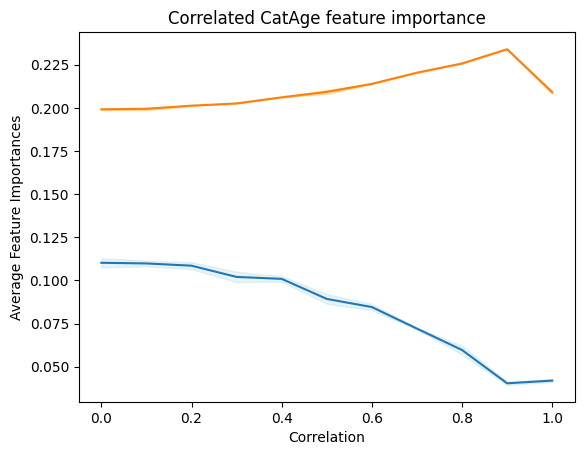

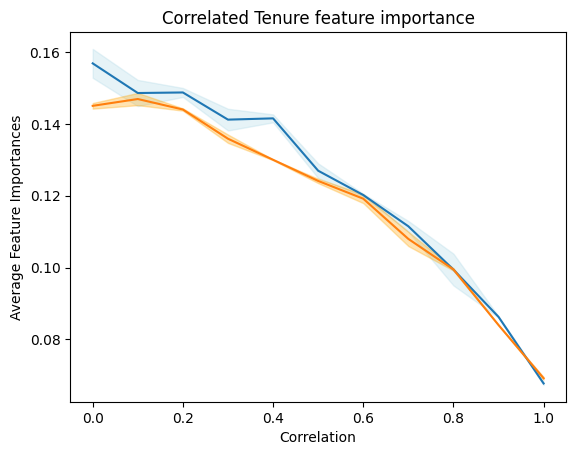

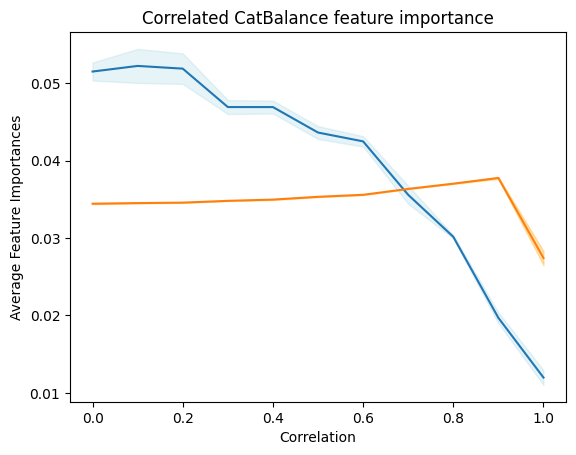

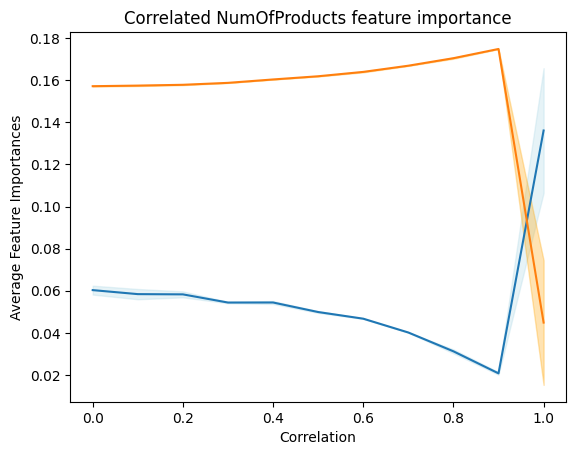

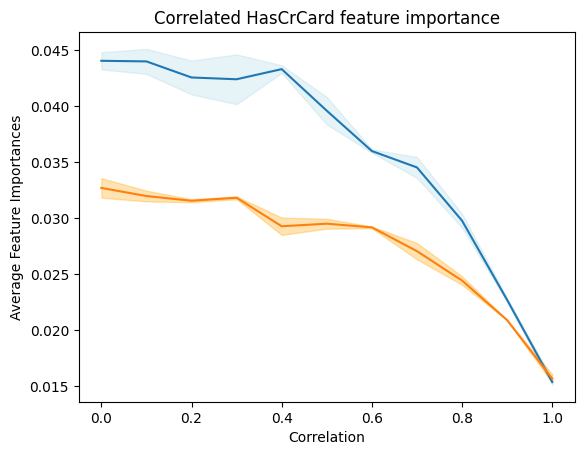

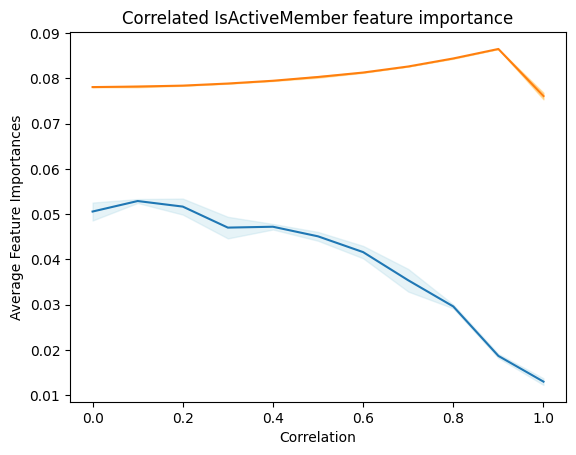

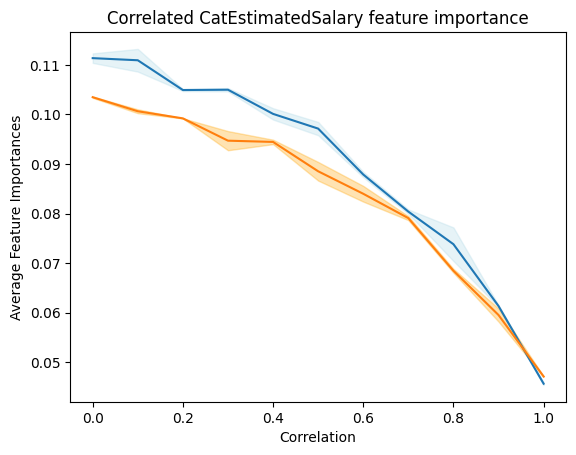

In [139]:
for var in X2.columns:
    plot_correlation_vs_importances2(X2, y2, copy_feature=var, num_seeds=2, mesh=11)

In [ ]:
model.fit(X2, y2)
import graphviz
from sklearn import tree

out = tree.export_graphviz(model)
graphviz.Source(out)

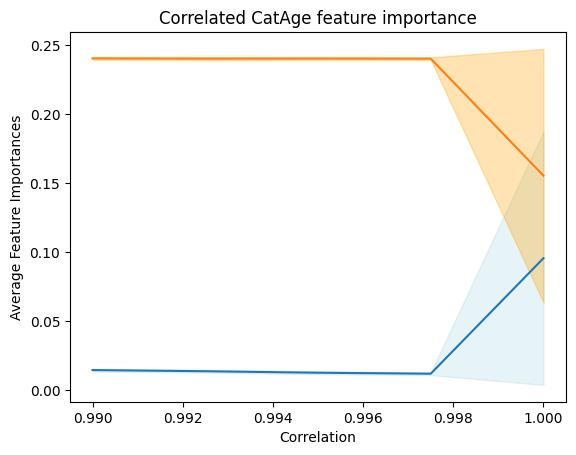

In [158]:
for var in ["CatAge"]:
    plot_correlation_vs_importances2(X2, y2, copy_feature=var, num_seeds=20, x=np.linspace(0.99,1,5))

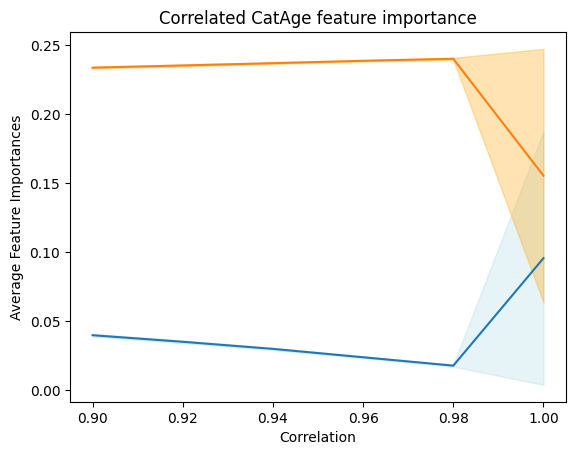

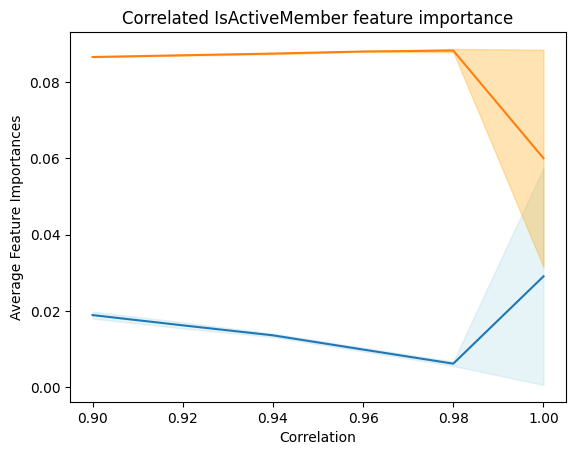

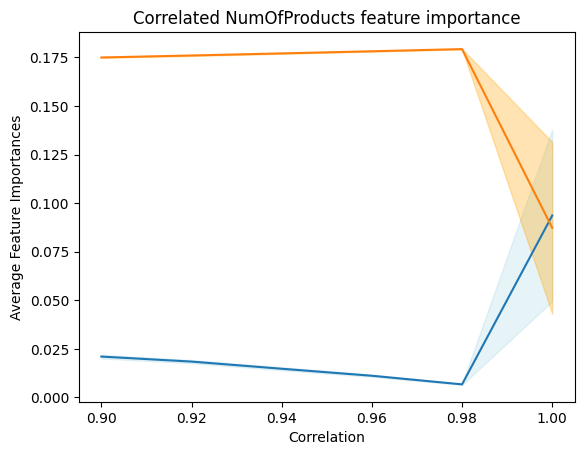

In [149]:
for var in ["CatAge", "IsActiveMember", "NumOfProducts"]:
    plot_correlation_vs_importances2(X2, y2, copy_feature=var, num_seeds=20, x=np.linspace(0.9,1,6))

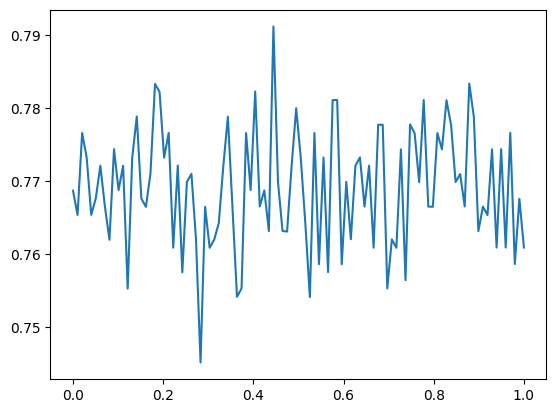

In [327]:
scorething=[]
mesh=100
for seed in range(mesh):
    model=DecisionTreeClassifier(random_state=seed)
    
    rfecv = RFECV(
        estimator=model,
        step=1,
        cv=cv_split,
        scoring="accuracy",
        n_jobs=-1,
    )
    X_with_dup = X_cont.copy()
    X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup["Age"], 0.8, seed=seed)
    rfecv.fit(X_with_dup, y)
    scorething.append(np.max(rfecv.cv_results_["mean_test_score"]))

x = np.linspace(0, 1, mesh)
plt.plot(x, scorething)

Especially bad if correlated variable was high cardinality...

Consider applying another dimensionality reduction technique such as PCA before using RFECV. PCA removes the highly correlated features from the dataset and makes RFECV more reliable as a second feature selection layer.

> We can see now that there may be merit in discarding variables thought to be measuring the same underlying (but "latent") aspect of a collection of variables, because including the nearly-redundant variables can cause the PCA to overemphasize their contribution. There is nothing mathematically right (or wrong) about such a procedure; it's a judgment call based on the analytical objectives and knowledge of the data. But it should be abundantly clear that setting aside variables known to be strongly correlated with others can have a substantial effect on the PCA results.

# Observations
### Low Cardinality

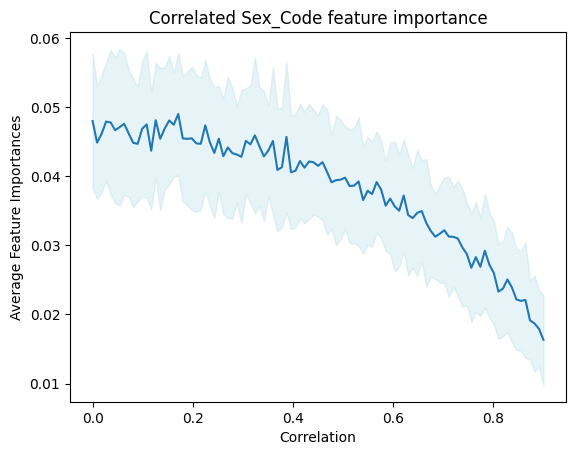

In [238]:
plot_correlation_vs_importances(model, X, y, copy_feature="Sex_Code", num_seeds=50)

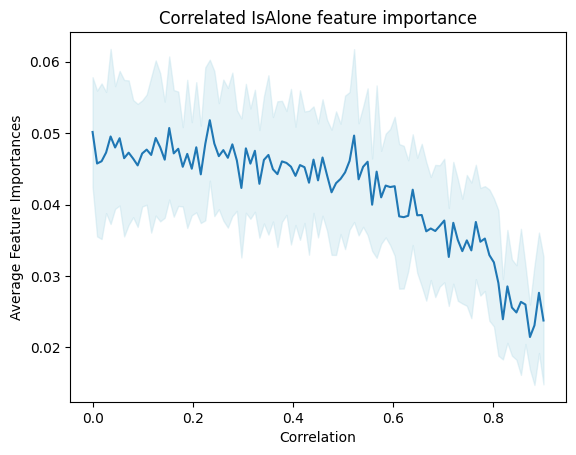

In [240]:
plot_correlation_vs_importances(model, X, y, copy_feature="IsAlone", num_seeds=20)

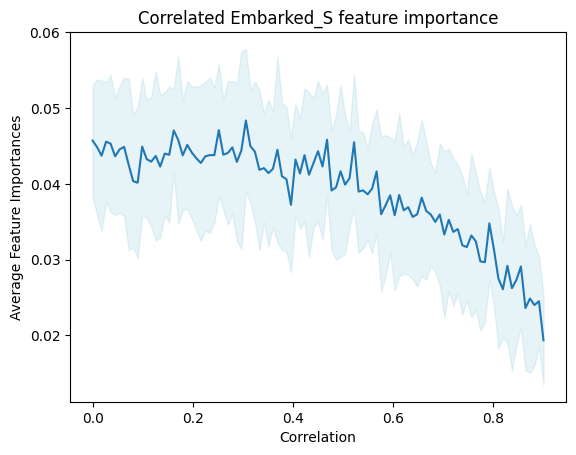

In [241]:
plot_correlation_vs_importances(model, X, y, copy_feature="Embarked_S", num_seeds=20)

### Medium Cardinality

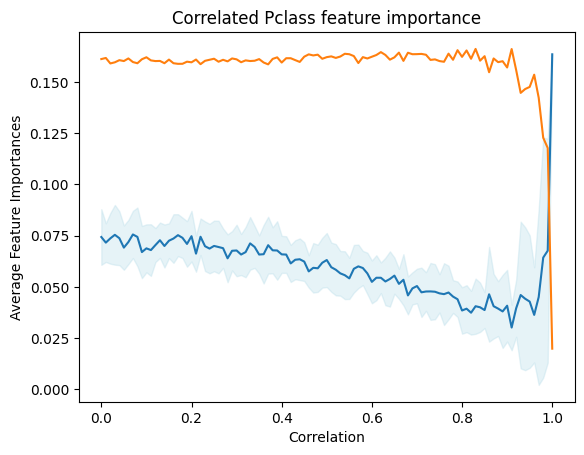

In [242]:
plot_correlation_vs_importances2(model, X, y, copy_feature="Pclass", num_seeds=20)

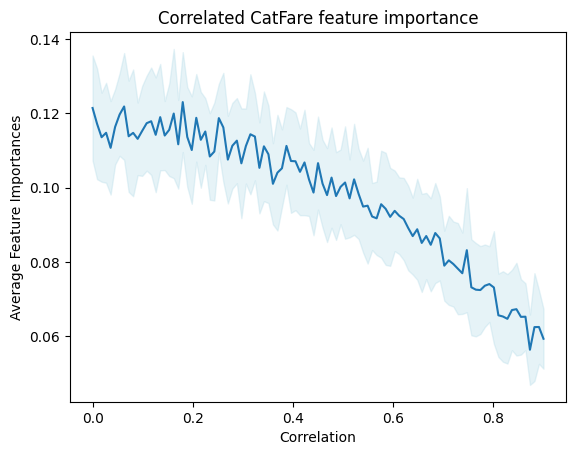

In [243]:
plot_correlation_vs_importances(model, X, y, copy_feature="CatFare", num_seeds=20)

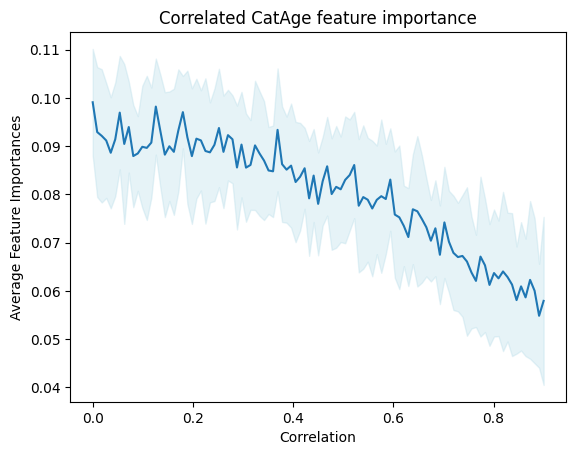

In [244]:
plot_correlation_vs_importances(model, X, y, copy_feature="CatAge", num_seeds=20)

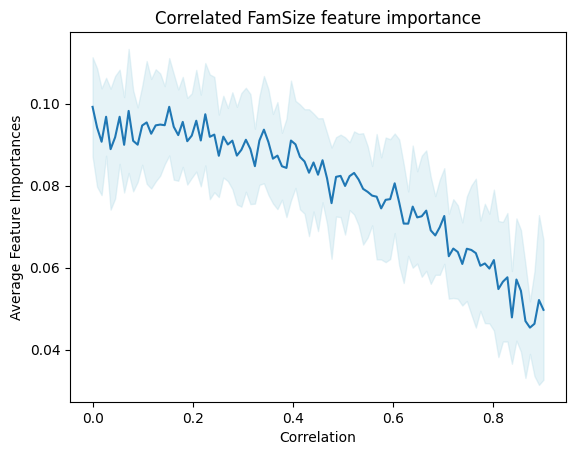

In [245]:
plot_correlation_vs_importances(model, X, y, copy_feature="FamSize", num_seeds=20)

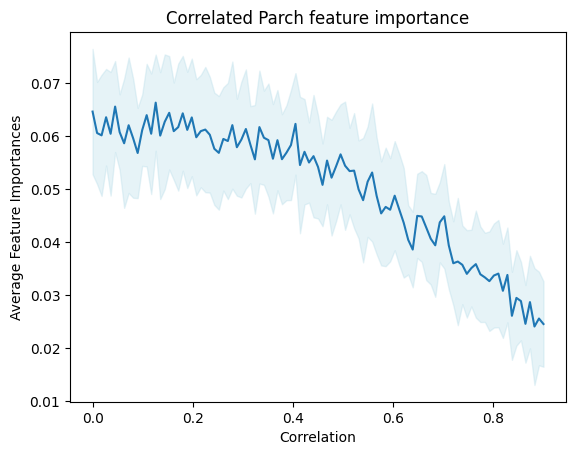

In [246]:
plot_correlation_vs_importances(model, X, y, copy_feature="Parch", num_seeds=20)

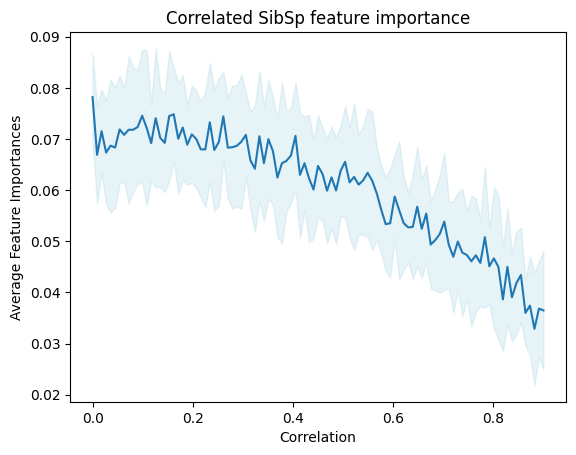

In [247]:
plot_correlation_vs_importances(model, X, y, copy_feature="SibSp", num_seeds=20)

### High Cardinality

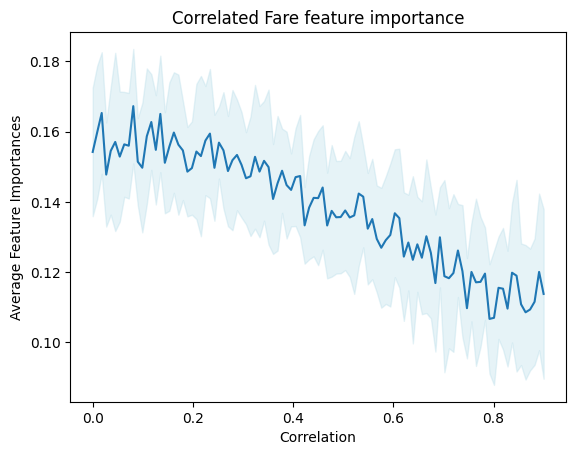

In [248]:
plot_correlation_vs_importances(model, X_cont, y, copy_feature="Fare", num_seeds=20)

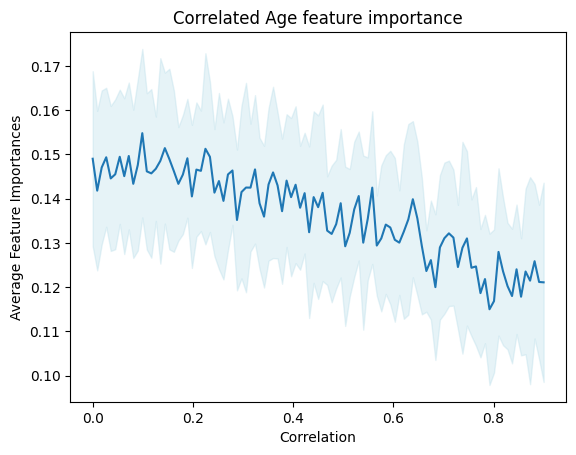

In [249]:
plot_correlation_vs_importances(model, X_cont, y, copy_feature="Age", num_seeds=20)

We see that RFECV does not have a problem with highly correlated features, since they will have very low feature importance anyway. 

There is no problem with having correlated variables, since RFECV is designed best to tackle this:

> When the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others.
> 
> However once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature.
> 
> As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features, But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

Source: https://blog.datadive.net/selecting-good-features-part-iii-random-forests/

<a id="10"></a>
# Conclusion

In summary when using RFECV:


* See specific feature importances and how they are calcul, ex. decision tree avoid cardinality. Since the features have large cardinality and the classifier is non-overfitted,we can rely on feat import/RFECV. Prior to inspecting the feature importances, it is important to check that the model predictive performance is high enough. Indeed there would be little interest of inspecting the important features of a non-predictive model.
* Feature importance scores quantify the extent to which a model relies on a feature to make predictions. They do not (necessarily) quantify the contribution of a feature to the overall accuracy of a model (i.e. the feature's usefulness). This is a subtle but fundamental difference.

I hope you have evolved your understanding of RFE and RFECV while exploring it. I recommend you to fork this kernel and play around with it using your own dataset and models. This will check if these results are consistent, and if not under what circumstances the results differ.

# Thank you for reading this kernel. Please leave a comment/upvote if you found this useful :3 